# **Klasifikasi Tweet Bencana Menggunakan Naive Bayes dan Logistic Regression**

Di era media sosial, informasi menyebar dengan sangat cepat. Sebuah tweet yang menggunakan kata "fire" (kebakaran) bisa berarti laporan bencana nyata, atau bisa juga hanya sebuah ungkapan metafora untuk sesuatu yang luar biasa ("this song is fire!"). Kemampuan untuk membedakan keduanya secara otomatis sangat krusial bagi organisasi pemantau bencana atau tim berita untuk memberikan respons yang cepat dan tepat.

Tujuan utama dari proyek ini adalah untuk membangun dan mengevaluasi beberapa model *machine learning* yang mampu mengklasifikasikan sebuah tweet ke dalam dua kategori:
1.  **Bencana (Target = 1)**: Tweet tersebut mengandung informasi tentang bencana nyata.
2.  **Bukan Bencana (Target = 0)**: Tweet tersebut tidak berhubungan dengan bencana.

Selain itu, sebagai langkah interpretasi model, kami juga akan mencoba mengekstrak informasi lokasi dari tweet yang berhasil diidentifikasi sebagai tweet bencana.

Dataset yang digunakan berasal dari kompetisi Kaggle "Natural Language Processing with Disaster Tweets". Dataset ini berisi kolom-kolom kunci seperti `text` (isi tweet) dan `target` (label 0 atau 1), serta kolom metadata lainnya seperti `keyword` dan `location` (lokasi profil pengguna).


Proyek ini akan melalui beberapa tahapan utama:
1.  **Analisis Data Eksploratif (EDA)**: Memahami karakteristik data dan membentuk asumsi awal.
2.  **Preprocessing Teks**: Membersihkan dan menstandardisasi data teks untuk persiapan pemodelan.
3.  **Feature Engineering & Vektorisasi**: Mengubah teks menjadi representasi numerik menggunakan TF-IDF.
4.  **Pemodelan & Tuning**: Melatih, menguji, dan melakukan *grid search* untuk menemukan parameter terbaik bagi beberapa varian model Naive Bayes (Multinomial, Bernoulli, Complement) dan Logistic Regression.
5.  **Evaluasi**: Menganalisis performa model dengan fokus utama pada metrik **Recall** untuk meminimalkan risiko melewatkan bencana nyata.
6.  **Interpretasi Model**: Menggunakan *Named Entity Recognition* (NER) untuk mengekstrak informasi lokasi dari tweet yang relevan.

# Load Data and Libraries

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
import string
import nltk
import time
import re
import os
import requests
import spacy


from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_validate, ParameterGrid, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_recall_curve
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid

from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk import word_tokenize, pos_tag
from scipy.sparse import hstack
from collections import Counter
from nltk.corpus import stopwords
from textblob import TextBlob
from tqdm import tqdm

sns.set(style="ticks", color_codes=True)
random_state = 99
'Done'

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker')
nltk.download('words')

np.random.seed(1611)
plt.style.use('default')    # Reset style matplotlib
plt.rcdefaults()            # Reset rcParams ke default
sns.reset_defaults()        # Reset style seaborn

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
# Load data
try:
    train_df = pd.read_csv("https://raw.githubusercontent.com/Alfa4026/NLP_2025/main/UTS/Datasets/train.csv")
    test_df  = pd.read_csv("https://raw.githubusercontent.com/Alfa4026/NLP_2025/main/UTS/Datasets/test.csv")
except:
    train_df = pd.read_csv("https://drive.google.com/uc?id=1ihd1SGi31mKs6u-UhTSh4oV4HwukGzkU")
    test_df  = pd.read_csv("https://drive.google.com/uc?id=1EmAmpoohDoUzN_vTj68XGL1e2GyHWm5N")


print(f"total data train: {train_df.shape[0]}\ntotal data test : {test_df .shape[0]}")


total data train: 7613
total data test : 3263


# EDA

In [ ]:
# Tampilkan 5 baris pertama dari data train
train_df.sample(10)

,id,keyword,location,text,target
3849,5477,flames,houstn,that new lil b x chance is nothing but flames,0
1583,2285,cliff%20fall,Inside your mind.,Photographer Brian Ruebs endures 4500-feet cli...,0
6460,9242,sunk,mainly California,why wasn't this warship sunk? CNN: First ...,1
2715,3900,devastated,PG Chillin!,Man Currensy really be talkin that talk... I'd...,1
5189,7408,obliterated,#freegucci,Me- Don't bother calling or texting me because...,0
5300,7570,outbreak,NaN,Families to sue over Legionnaires: More than 4...,1
4060,5769,forest%20fires,NaN,#HeartDisease U.S. Forest Service says spendin...,1
2039,2927,danger,Spinning through time.,@riverroaming 'And not too much danger please.',0
6727,9640,thunderstorm,NaN,Falling asleep to the sounds to thousands of R...,0
2058,2952,danger,NaN,Fear has a way of making us see danger where t...,0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
# melihat total target di tiap kelas pada data train
train_df['target'].value_counts()

,count
target,
0,4342
1,3271


### Periksa Duplikasi Data

In [ ]:
print('Jumlah Duplikasi data pada dataset Train :' ,train_df.duplicated(['text']).sum())

Jumlah Duplikasi data pada dataset Train : 110


In [ ]:
# hanya berupa duplikasinya saja, baris pertama (yang aslinya) tidak disertakan
train_df[train_df.duplicated(['text'], keep='first')]

,id,keyword,location,text,target
48,68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
115,165,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
119,172,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0
164,238,airplane%20accident,NaN,Experts in France begin examining airplane deb...,1
624,898,bioterrorism,NaN,To fight bioterrorism sir.,0
...,...,...,...,...,...
7600,10855,NaN,NaN,Evacuation order lifted for town of Roosevelt:...,1
7607,10867,NaN,NaN,#stormchase Violent Record Breaking EF-5 El Re...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


In [ ]:
# Tujuannya untuk melihat baris dengan id berapa yang diduplikasi di kolom text oleh baris dengan id berapa

# Buat dataframe hanya dengan kolom id dan text
df_duplikat = train_df[train_df.duplicated(['text'], keep=False)][['id', 'text']]

# Gabungkan dataframe dengan dirinya sendiri berdasarkan kolom 'text'
df_pasang = df_duplikat.merge(df_duplikat, on='text')

# Hilangkan pasangan id yang sama (dengan filter)
df_pasang = df_pasang[df_pasang['id_x'] != df_pasang['id_y']]

# Hapus duplikat bolak-balik (misal: (1,2) dan (2,1))
df_pasang = df_pasang.drop_duplicates(subset=['id_x', 'id_y'], keep='first')

# Tampilkan hasil
df_pasang


,id_x,text,id_y
1,59,Check these out: http://t.co/rOI2NSmEJJ http:/...,68
2,68,Check these out: http://t.co/rOI2NSmEJJ http:/...,59
5,156,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,165
6,165,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,156
9,171,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,172
...,...,...,...
577,10855,Evacuation order lifted for town of Roosevelt:...,4850
579,10867,#stormchase Violent Record Breaking EF-5 El Re...,10169
581,10870,@aria_ahrary @TheTawniest The out of control w...,10470
583,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,10229


In [ ]:
# hanya verifikasi hasil dari kode sebelumnya
train_df[(train_df['id'] == 10867	) | (train_df['id'] == 10169)]

,id,keyword,location,text,target
7097,10169,violent%20storm,NaN,#stormchase Violent Record Breaking EF-5 El Re...,1
7607,10867,NaN,NaN,#stormchase Violent Record Breaking EF-5 El Re...,1


### Hapus Duplikasi Data

In [ ]:
train_df2 = train_df.drop_duplicates(["text"], inplace=False)

In [ ]:
train_df2.shape

(7503, 5)

### Periksa Missing Value

In [ ]:
print("Missing values di Train dataset : ")
null_train = train_df2.isnull().sum().to_frame().rename(columns={0:'Missing values'})
null_train["Missing values percentage %"] = train_df2.isnull().sum() * 100 / len(train_df2)
null_train.style

Missing values di Train dataset : 


,Missing values,Missing values percentage %
id,0,0.000000
keyword,56,0.746368
location,2482,33.080101
text,0,0.000000
target,0,0.000000


### Analisis Variabel Target
kami perlu tahu seberapa seimbang distribusi antara tweet bencana dan non-bencana.

In [ ]:
import plotly.express as px

# Hitung jumlah tiap target
target_counts = train_df2["target"].value_counts().rename({0: "Not Disaster (0)", 1: "Disaster (1)"}).reset_index()
target_counts.columns = ['Label', 'Count']

# Buat pie chart interaktif
fig = px.pie(
    target_counts,
    names='Label',
    values='Count',
    title='📊 Distribution of Disaster vs Non-Disaster Tweets',
    color_discrete_sequence=['#AEDFF7', '#FFB3AB'],
    hole=0.3  # Jika ingin donut chart, set ke 0.3 atau 0.4
)

fig.update_traces(
    textinfo='percent+label',
    pull=[0.05, 0.05],  # Melebar seperti explode
    hovertemplate='<b>%{label}</b><br>Jumlah: %{value}<br>Persen: %{percent}'
)

fig.update_layout(
    title_font_size=18,
    title_x=0.5,
    showlegend=True
)

fig.show()


>**Observasi:**
* Kelas "Non-Bencana" (target=0) merupakan mayoritas dengan total 4342 tweet, atau sekitar 57.03% dari keseluruhan data setelah menghapus duplikasi.
* Kelas "Bencana" (target=1) mencakup 3271 tweet, yang setara dengan 42.97% dari data.
* Secara visual, dataset ini dapat dianggap **cukup seimbang**, karena tidak ada satu kelas pun yang mendominasi secara ekstrem.

---

### Analisis Fitur Teks - Panjang Tweet
Apakah ada perbedaan panjang kalimat antara tweet bencana dan non-bencana?

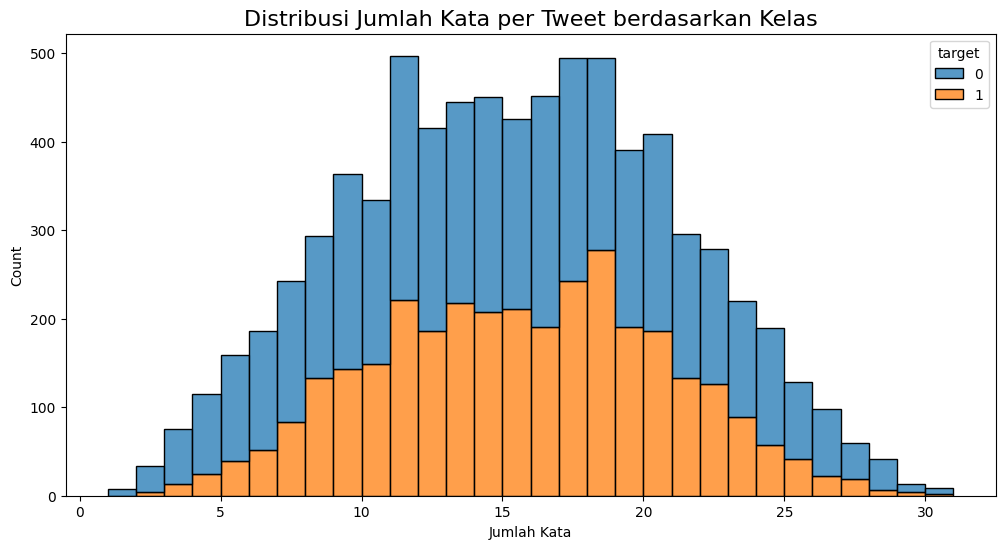

         count       mean       std  min   25%   50%   75%   max
target                                                          
0       4342.0  14.704744  6.161564  1.0  10.0  15.0  19.0  31.0
1       3271.0  15.167533  5.096806  2.0  11.0  15.0  19.0  30.0


In [ ]:
# --- Sel 3: Analisis Panjang Teks ---

# Membuat fitur baru untuk jumlah karakter dan jumlah kata
train_df['char_count'] = train_df['text'].apply(len)
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))

# Membuat plot distribusi untuk jumlah kata
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='word_count', hue='target', multiple='stack', bins=30)
plt.title('Distribusi Jumlah Kata per Tweet berdasarkan Kelas', fontsize=16)
plt.xlabel('Jumlah Kata')
plt.show()

# Melihat statistik deskriptif
print(train_df.groupby('target')['word_count'].describe())

>**Observasi:**
* Distribusi jumlah kata untuk kedua kelas (bencana dan non-bencana) menunjukkan pola yang sangat mirip dan sebagian besar tumpang tindih.
* Puncak distribusi (jumlah kata yang paling sering muncul) untuk kedua kelas berada di sekitar 13-15 kata per tweet.
* Secara statistik, rata-rata jumlah kata untuk tweet bencana (15.1 kata) hanya sedikit lebih tinggi dibandingkan tweet non-bencana (14.7 kata). Perbedaan ini tidak signifikan secara visual.

---

### Analisis Kosakata - Kata Paling Umum

Ini adalah bagian EDA paling penting untuk NLP. Kata-kata apa yang paling sering muncul di masing-masing kelas?

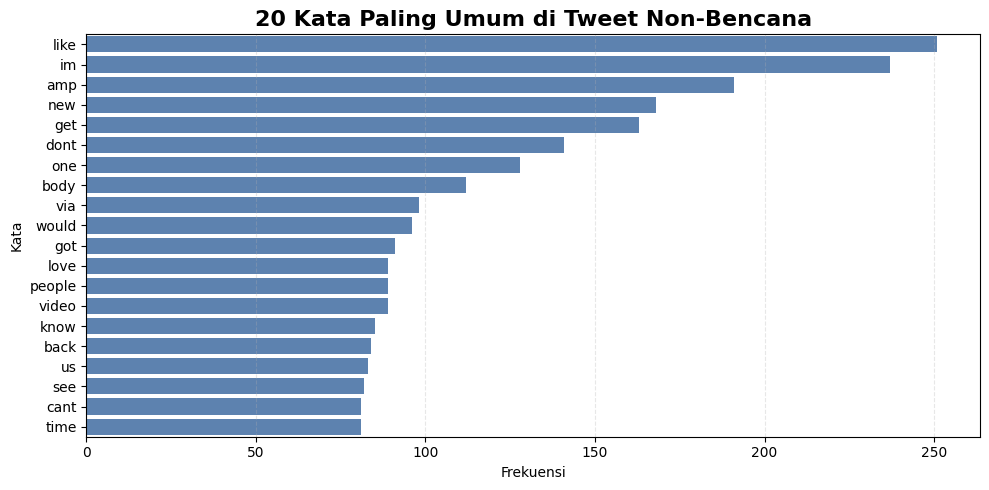

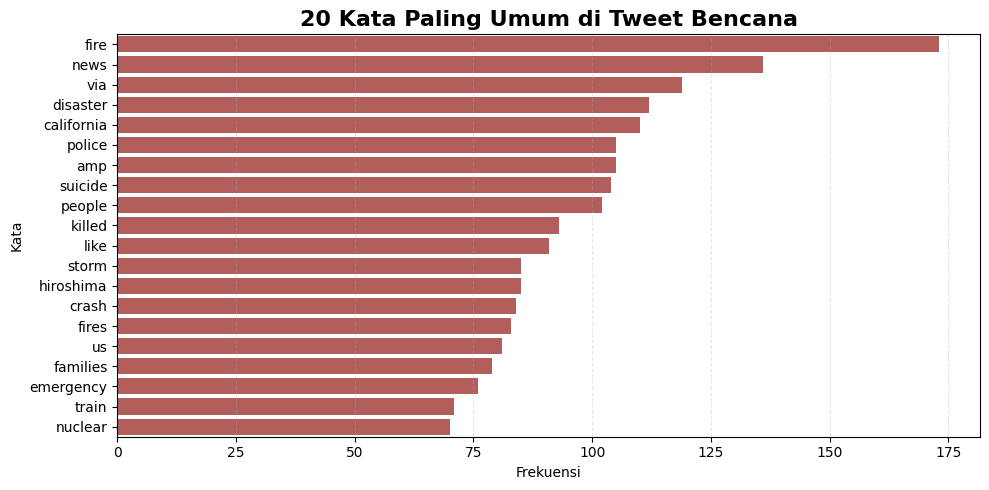

In [ ]:
# Fungsi pembersih teks
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text.strip()

# Siapkan stopwords satu kali
stop_words = set(stopwords.words('english'))

# Fungsi visualisasi kata paling umum
def plot_top_words(corpus, title, n=20, color='#4F81BD'):
    cleaned_corpus = [preprocess_text(text) for text in corpus]
    all_text = ' '.join(cleaned_corpus)
    tokens = word_tokenize(all_text)
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    word_counts = Counter(filtered_tokens)
    top_words = word_counts.most_common(n)

    words, freqs = zip(*top_words)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(freqs), y=list(words), color=color)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Frekuensi')
    plt.ylabel('Kata')
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot untuk tweet Non-Bencana (target = 0) → biru
plot_top_words(
    train_df2[train_df2['target'] == 0]['text'],
    '20 Kata Paling Umum di Tweet Non-Bencana',
    color='#4F81BD'
)

# Plot untuk tweet Bencana (target = 1) → merah
plot_top_words(
    train_df2[train_df2['target'] == 1]['text'],
    '20 Kata Paling Umum di Tweet Bencana',
    color='#C0504D'
)


>**Observasi:**
* Terdapat perbedaan yang sangat kontras dalam kosakata yang digunakan oleh kedua kelas.
* Grafik untuk tweet **non-bencana (target=0)** didominasi oleh kata-kata umum dan sering terkait interaksi sosial atau media, seperti *'like'*, *'im'*, *'new'*, *'get'*, dan *'people'*.
* Sebaliknya, grafik untuk tweet **bencana (target=1)** secara jelas menampilkan kosakata yang sangat spesifik terkait peristiwa darurat, seperti *'fire'*, *'suicide'*, *'crash'*, *'killed'*, *'disaster'*, dan *'bomber'*.

# Data Preprocessing (cleaning text)

In [ ]:
# Jalankan Cell ini "HANYA" jika anda menggunakan Google Colab
# Jika di jalankan di komputer local, silahkan lihat NLPTM-02 untuk instalasinya.
import warnings; warnings.simplefilter('ignore')
import nltk

try:
    import google.colab; IN_COLAB = True
    !wget https://raw.githubusercontent.com/taudataanalytics/taudata-Academy/d352ef3839f8b2d4da056dd67904bc38ce32f48e/taudataNlpTm.py
    !mkdir data
    !wget -P data/ https://raw.githubusercontent.com/taudataanalytics/taudata-Academy/d352ef3839f8b2d4da056dd67904bc38ce32f48e/data/slang.txt
    !wget -P data/ https://raw.githubusercontent.com/taudataanalytics/taudata-Academy/d352ef3839f8b2d4da056dd67904bc38ce32f48e/data/stopwords_id.txt
    !wget -P data/ https://raw.githubusercontent.com/taudataanalytics/taudata-Academy/d352ef3839f8b2d4da056dd67904bc38ce32f48e/data/stopwords_en.txt
    !wget -P data/ https://raw.githubusercontent.com/taudataanalytics/taudata-Academy/d352ef3839f8b2d4da056dd67904bc38ce32f48e/data/kata_dasar.txt
    !wget -P data/ https://raw.githubusercontent.com/taudataanalytics/taudata-Academy/d352ef3839f8b2d4da056dd67904bc38ce32f48e/data/wn-ind-def.tab
    !wget -P data/ https://raw.githubusercontent.com/taudataanalytics/taudata-Academy/d352ef3839f8b2d4da056dd67904bc38ce32f48e/data/wn-msa-all.tab
    !wget -P data/ https://raw.githubusercontent.com/taudataanalytics/taudata-Academy/d352ef3839f8b2d4da056dd67904bc38ce32f48e/data/ind_SA.csv
    !wget -P data/ https://raw.githubusercontent.com/taudataanalytics/taudata-Academy/d352ef3839f8b2d4da056dd67904bc38ce32f48e/data/all_indo_man_tag_corpus_model.crf.tagger

    !pip install spacy python-crfsuite unidecode textblob sastrawi
    !python -m spacy download xx
    !python -m spacy download en_core_web_sm

    nltk.download('popular')
except:
    IN_COLAB = False
    print("Running the code locally, please make sure all the python module versions agree with colab environment and all data/assets downloaded")

--2025-07-16 15:44:14--  https://raw.githubusercontent.com/taudataanalytics/taudata-Academy/d352ef3839f8b2d4da056dd67904bc38ce32f48e/taudataNlpTm.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14001 (14K) [text/plain]
Saving to: ‘taudataNlpTm.py’

taudataNlpTm.py     100%[===================>]  13.67K  --.-KB/s    in 0s      

2025-07-16 15:44:14 (31.7 MB/s) - ‘taudataNlpTm.py’ saved [14001/14001]

--2025-07-16 15:44:14--  https://raw.githubusercontent.com/taudataanalytics/taudata-Academy/d352ef3839f8b2d4da056dd67904bc38ce32f48e/data/slang.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... 

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

In [ ]:
# Download resource NLTK (hanya perlu sekali)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger') # This one might be enough, but eng is specific
nltk.download('averaged_perceptron_tagger_eng') # Add this line to be sure
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_

True

In [ ]:
train_df = train_df2
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7604,10863,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1
7605,10864,NaN,NaN,on the flip side I'm at Walmart and there is a...,1
7606,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1


In [ ]:
# preprocessing
import taudataNlpTm as tau
from tqdm import tqdm
stops, lemmatizer = tau.LoadStopWords(lang='en')
d = "you won't do it, like chickens!"
tau.cleanText(d, lemma=False, stops = False, symbols_remove = True, min_charLen = 2, lan='en')

"you wo n't do it like chickens"

In [ ]:
# preprocessing
import taudataNlpTm as tau
from tqdm import tqdm
D = train_df['text'].to_list()
stops, lemmatizer = tau.LoadStopWords(lang='en')
for i,d in tqdm(enumerate(D)):
    D[i] = tau.cleanText(d, lemma=lemmatizer, stops = stops, symbols_remove = True, min_charLen = 2, lan='en')
print(D[0])
train_df['cleaned_text'] = D
train_df

7503it [01:47, 69.55it/s]


deed reason earthquake allah forgive


,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident ask ' shelter place notify officer ev...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,receive wildfire evacuation order california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,photo ruby alaska smoke wildfire pour school
...,...,...,...,...,...,...
7604,10863,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1,news fall powerline link tram update crew evac...
7605,10864,NaN,NaN,on the flip side I'm at Walmart and there is a...,1,flip ' m walmart bomb evacuate stay tuned blow
7606,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1,suicide bomber kill saudi security site mosque...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,giant crane hold bridge collapse nearby home


In [ ]:
train_df[['text','cleaned_text']].head()

,text,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,forest ronge sask canada
2,All residents asked to 'shelter in place' are ...,resident ask ' shelter place notify officer ev...
3,"13,000 people receive #wildfires evacuation or...",receive wildfire evacuation order california
4,Just got sent this photo from Ruby #Alaska as ...,photo ruby alaska smoke wildfire pour school


# Rangkuman EDA dan Strategi Pemodelan

###**Wawasan dari Analisis Data**

Berdasarkan hasil *exploratory data analysis (EDA)*, kami merangkum tiga temuan utama dari visualisasi yang telah dibuat. Temuan-temuan ini menjadi dasar dalam menentukan langkah *preprocessing*, pemilihan fitur, hingga strategi evaluasi model.

1. **Distribusi Kelas (Pie Chart):**
   Data terbagi cukup seimbang, dengan sekitar 57% tweet non-bencana dan 43% tweet bencana. Ini merupakan kondisi ideal karena tidak memerlukan teknik penyeimbangan data tambahan. Namun, karena distribusinya relatif seimbang, *akurasi* saja tidak cukup untuk mengevaluasi performa model secara menyeluruh. Metrik lain seperti *precision*, *recall*, dan *F1-score* menjadi lebih penting.

2. **Panjang Tweet (Histogram Jumlah Kata):**
   Rata-rata panjang tweet pada kedua kelas terlihat serupa, tanpa perbedaan mencolok. Ini menunjukkan bahwa panjang teks bukanlah faktor pembeda yang kuat antara tweet bencana dan non-bencana. Artinya, kita perlu mencari sinyal yang lebih bermakna dari konten kata-katanya, bukan dari struktur atau panjang kalimat.

3. **Kosakata Umum (Bar Plot):**
   Di sinilah perbedaan paling mencolok terlihat. Tweet bertema bencana cenderung memuat kata-kata seperti *"fire"*, *"crash"*, *"flood"*, dan *"fatalities"*, sedangkan tweet non-bencana lebih sering mengandung kata-kata umum seperti *"like"*, *"new"*, dan *"love"*. Ini menunjukkan bahwa **isi atau jenis kata yang digunakan merupakan sinyal utama** dalam membedakan kedua kelas.

---
### Strategi Pemodelan dan Evaluasi

Setelah melihat hasil EDA dan memahami tujuan proyek, kami menyusun strategi yang realistis dan fokus untuk memilih model klasifikasi yang paling sesuai.

* **Kenapa Recall Jadi Prioritas:**
  Karena sistem ini dirancang untuk mendeteksi bencana sejak dini, kesalahan paling berbahaya adalah saat sistem **gagal mendeteksi bencana yang sebenarnya terjadi (False Negative)**. Jadi, **Recall** untuk kelas bencana kami anggap sebagai metrik yang paling penting. Tapi kami juga sadar, kalau terlalu fokus ke Recall saja, bisa muncul banyak alarm palsu (False Positive), dan itu bisa bikin orang kehilangan kepercayaan pada sistem.

* **Solusi: Skor Terbobot (Weighted Score)**
  Supaya penilaian model lebih seimbang, kami pakai skor buatan sendiri yang mempertimbangkan tiga hal sekaligus: **Recall, F1-Score**, dan **Accuracy**. Recall tetap kami beri bobot paling besar, tapi F1 dan Accuracy juga tetap ikut diperhitungkan.

  Dengan cara ini, kami bisa memilih model yang:

  1. **Cukup sensitif** buat mendeteksi bencana (Recall tinggi),
  2. **Nggak terlalu banyak salah deteksi** (F1-Score seimbang),
  3. **Secara umum performanya bagus** (Accuracy tetap dijaga).

* **Fokus pada Fitur Teks:**
  Dari analisis awal, kami lihat bahwa kata-kata dalam teks cukup kuat sebagai penanda bencana. Karena itu, kami pakai **TF-IDF Vectorizer** sebagai fitur utama. Kami juga coba berbagai variasi **N-gram**—misalnya unigram saja `(1,1)` atau kombinasinya dengan bigram `(1,2)`—untuk lihat mana yang paling efektif. Semuanya diuji lewat *grid search* yang cukup menyeluruh.

---

### Rencana Eksekusi

Kami akan melatih dan bandingkan beberapa model: **Multinomial Naive Bayes**, **Complement Naive Bayes**, dan **Logistic Regression**. Dari masing-masing model, kami ambil yang performanya paling bagus berdasarkan **skor terbobot** tadi. Tujuannya jelas: dapat model yang **sensitif, cukup presisi, dan tetap stabil secara keseluruhan**.

---


# Model Building

Pada bagian ini kami melakukan **Text Vectorization** menggunakan **TF-IDF** karena metode ini tidak hanya menghitung frekuensi kata, tetapi juga memberikan bobot yang lebih tinggi pada kata-kata yang unik untuk dokumen tertentu, sehingga membantu model fokus pada sinyal yang lebih informatif.

Kami juga melakukan **Evaluation** berdasarkan metrik `accuracy`, `f1_score`, dan `recall` untuk mendapatkan gambaran performa yang komprehensif. Tahapan **Validation** menggunakan **K-Fold Cross-Validation (dengan `cv=5`)** untuk memastikan skor yang kami dapatkan stabil dan tidak bergantung pada satu pembagian data acak saja.

Pada semua algoritma yang kami gunakan, yaitu varian Naive Bayes dan Logistic Regression, kami melakukan **Grid Search** yang luas pada berbagai kombinasi parameter data dan model untuk menemukan konfigurasi terbaik sesuai dengan metrik yang kami prioritaskan.

---

Parameter untuk Data:
- **tfidf__max_df**, mengapa digunakan? Untuk mengabaikan kata-kata yang muncul terlalu sering di seluruh dokumen (misal: lebih dari 95% dokumen). Kata-kata ini seringkali merupakan *corpus-specific stopwords* yang tidak informatif.
- **tfidf__min_df**, mengapa digunakan? Untuk mengabaikan kata-kata yang muncul terlalu jarang (misal: hanya di 1 atau 2 dokumen). Kata-kata ini seringkali merupakan salah ketik (*typo*) atau *noise* yang tidak memiliki pola.
- **tfidf__ngram_range**, mengapa digunakan? Untuk menangkap konteks. `(1, 2)` berarti model akan melihat kata tunggal (unigram) dan pasangan kata (bigram) sebagai fitur. Ini penting untuk memahami frasa seperti "suicide bomber" sebagai satu kesatuan.
- **tfidf__smooth_idf**, mengapa digunakan? Untuk mencegah error pembagian dengan nol saat menghitung bobot IDF. Ini dilakukan dengan menambahkan nilai 1 ke frekuensi dokumen.
- **tfidf__stop_words**, mengapa digunakan? Untuk menghapus kata-kata umum dalam Bahasa Inggris (seperti 'the', 'a', 'in') yang tidak membawa banyak makna prediktif dan hanya menambah kompleksitas.
- **tfidf__sublinear_tf**, mengapa digunakan? Untuk menerapkan penskalaan logaritmik pada frekuensi kata (`1 + log(tf)`). Ini mengurangi dampak dari kata yang muncul sangat sering, karena perbedaan antara 10 dan 20 kemunculan dianggap lebih penting daripada perbedaan antara 100 dan 110.
- **use_hapus_kosong**, mengapa digunakan? Sebagai langkah pengamanan untuk menghapus dokumen yang mungkin menjadi kosong setelah proses preprocessing (misalnya, tweet yang hanya berisi stopwords atau URL).
- **use_selectkbest**, mengapa digunakan? Untuk melakukan seleksi fitur. Ini akan memilih `k` fitur teratas yang paling informatif berdasarkan uji statistik Chi-Squared, mengurangi *noise* dan dimensi data sebelum dimasukkan ke model.
- **k_chi**, mengapa digunakan? Menentukan jumlah `k` fitur terbaik yang akan dipilih oleh `SelectKBest` saat `use_selectkbest` diaktifkan.

**Tujuannya**: Semua parameter ini diuji dalam *grid search* untuk secara sistematis menemukan kombinasi terbaik antara representasi teks dan seleksi fitur yang menghasilkan model paling baik.

---

In [ ]:
def hapusKosong(X,Y):
    Y = Y[X.getnnz(1)>0] # delete label dokumen yang memiliki row =0 di tfidf-nya
    X = X[X.getnnz(1)>0] # Remove Zero Rows
    return X, Y

## Percobaan menggunakan Multinomial Naive Bayes


Parameter Model:
- **clf__alpha**, mengapa digunakan? Ini adalah parameter *smoothing* (Laplace atau Lidstone). Nilainya (biasanya antara 0 dan 1) digunakan untuk mengatasi masalah kata pada data uji yang tidak pernah muncul pada data latih, sehingga mencegah probabilitas menjadi nol.
- **clf__fit_prior**, mengapa digunakan? Menentukan apakah model perlu belajar probabilitas awal dari setiap kelas (`P(kelas)`). Sebaiknya `True` jika dataset tidak seimbang, tetapi diuji juga dengan `False` untuk melihat dampaknya.


In [ ]:
TRAIN = train_df['cleaned_text']
target = train_df['target']
X_train, X_test, y_train, y_test = train_test_split(TRAIN, target, test_size=0.1, random_state=99, stratify=target)


### Data val pada cross validation **tidak** ikut di preprocess (fit_transform)

In [ ]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold, cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm import tqdm

# Parameter grid dasar
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [0.5, 0.7, 0.9],
    'tfidf__min_df': [1, 2],
    'tfidf__sublinear_tf': [True, False],
    'tfidf__smooth_idf': [True],
    'tfidf__stop_words': ['english'],
    'clf__alpha': [0.01, 0.1, 0.5, 1.0],
    'clf__fit_prior': [True, False],
    'selectk__score_func': [chi2, f_classif]
}

base_grid = list(ParameterGrid(param_grid))
k_range = list(range(3000, 7000, 1000))

# Ekspansi grid dengan opsi preprocessing tambahan
expanded_grid = []
for params in base_grid:
    for use_clean in [True]:
        for use_kbest in [True, False]:
            if use_kbest:
                for k in k_range:
                    new_params = params.copy()
                    new_params.update({
                        'use_hapus_kosong': use_clean,
                        'use_selectkbest': True,
                        'k_chi': k
                    })
                    expanded_grid.append(new_params)
            else:
                new_params = params.copy()
                new_params.update({
                    'use_hapus_kosong': use_clean,
                    'use_selectkbest': False,
                    'k_chi': None
                })
                expanded_grid.append(new_params)

results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)

for params in tqdm(expanded_grid, desc="Grid Search all variants"):
    use_hapus_kosong = params.pop('use_hapus_kosong')
    use_selectkbest = params.pop('use_selectkbest')
    k = params.pop('k_chi')

    # try:
    ypred = []
    yval = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        # Fix: Use .iloc for integer-based indexing
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        vectorizer = TfidfVectorizer(
            ngram_range=params['tfidf__ngram_range'],
            max_df=params['tfidf__max_df'],
            min_df=params['tfidf__min_df'],
            sublinear_tf=params['tfidf__sublinear_tf'],
            smooth_idf=params['tfidf__smooth_idf'],
            stop_words=params['tfidf__stop_words']
        )

        clf = MultinomialNB(
            alpha=params['clf__alpha'],
            fit_prior=params['clf__fit_prior']
        )
        selectk = SelectKBest(score_func=params['selectk__score_func'], k=k)

        X_tr = vectorizer.fit_transform(X_tr)
        X_val = vectorizer.transform(X_val)

        if use_selectkbest:
            X_tr = selectk.fit_transform(X_tr, y_tr)
            X_val = selectk.transform(X_val)

        if use_hapus_kosong:
            X_tr, y_tr = hapusKosong(X_tr, y_tr)
            # X_val, y_val = hapusKosong(X_val, y_val)

        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        ypred.extend(y_pred)
        yval.extend(y_val)

    acc = accuracy_score(yval, ypred)
    f1 = f1_score(yval, ypred, pos_label=1)
    recall_1 = recall_score(yval, ypred, pos_label=1)

    results.append({
        'params': params,
        'use_hapus_kosong': use_hapus_kosong,
        'use_selectkbest': use_selectkbest,
        'k_chi': k,
        'accuracy': acc,
        'f1_class_1': f1,
        'recall_1': recall_1
    })

    # except Exception as e:
    #     print(f"Skipped config due to error: {e}")
    #     continue

Grid Search all variants: 100%|██████████| 1920/1920 [37:08<00:00,  1.16s/it]


In [ ]:
# Temukan model terbaik berdasarkan masing-masing metrik
best_by_acc = max(results, key=lambda r: r['accuracy'])
best_by_f1 = max(results, key=lambda r: r['f1_class_1'])
best_by_recall = max(results, key=lambda r: r['recall_1'])

# Tampilkan hasil terbaik berdasarkan akurasi
print("\n📌 Best Model by Accuracy:")
print(f"Accuracy: {best_by_acc['accuracy']:.4f}")
print(f"F1 Score: {best_by_acc['f1_class_1']:.4f}")
print(f"Recall: {best_by_acc['recall_1']:.4f}")
print(f"Params: {best_by_acc['params']}")
print(f"use_hapus_kosong: {best_by_acc['use_hapus_kosong']}")
print(f"use_selectkbest: {best_by_acc['use_selectkbest']}, k_chi: {best_by_acc['k_chi']}")

# Tampilkan hasil terbaik berdasarkan F1-score kelas 1
print("\n📌 Best Model by F1 Score (class=1):")
print(f"Accuracy: {best_by_f1['accuracy']:.4f}")
print(f"F1 Score: {best_by_f1['f1_class_1']:.4f}")
print(f"Recall: {best_by_f1['recall_1']:.4f}")
print(f"Params: {best_by_f1['params']}")
print(f"use_hapus_kosong: {best_by_f1['use_hapus_kosong']}")
print(f"use_selectkbest: {best_by_f1['use_selectkbest']}, k_chi: {best_by_f1['k_chi']}")

# Tampilkan hasil terbaik berdasarkan Recall kelas 1
print("\n📌 Best Model by Recall (class=1):")
print(f"Accuracy: {best_by_recall['accuracy']:.4f}")
print(f"F1 Score: {best_by_recall['f1_class_1']:.4f}")
print(f"Recall: {best_by_recall['recall_1']:.4f}")
print(f"Params: {best_by_recall['params']}")
print(f"use_hapus_kosong: {best_by_recall['use_hapus_kosong']}")
print(f"use_selectkbest: {best_by_recall['use_selectkbest']}, k_chi: {best_by_recall['k_chi']}")


📌 Best Model by Accuracy:
Accuracy: 0.7992
F1 Score: 0.7368
Recall: 0.6595
Params: {'clf__alpha': 1.0, 'clf__fit_prior': True, 'selectk__score_func': <function f_classif at 0x7ad2c6d2e0c0>, 'tfidf__max_df': 0.5, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__smooth_idf': True, 'tfidf__stop_words': 'english', 'tfidf__sublinear_tf': True}
use_hapus_kosong: True
use_selectkbest: True, k_chi: 5000

📌 Best Model by F1 Score (class=1):
Accuracy: 0.7953
F1 Score: 0.7508
Recall: 0.7234
Params: {'clf__alpha': 1.0, 'clf__fit_prior': False, 'selectk__score_func': <function f_classif at 0x7ad2c6d2e0c0>, 'tfidf__max_df': 0.5, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__smooth_idf': True, 'tfidf__stop_words': 'english', 'tfidf__sublinear_tf': True}
use_hapus_kosong: True
use_selectkbest: True, k_chi: 5000

📌 Best Model by Recall (class=1):
Accuracy: 0.7756
F1 Score: 0.7407
Recall: 0.7519
Params: {'clf__alpha': 0.5, 'clf__fit_prior': False, 'selectk__score_func': <function c

#### Data test tidak di preprocess

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import numpy as np

def get_predictions_cv(results, cleaned_text, target):
    params = results['params']
    use_hapus_kosong = results['use_hapus_kosong']
    use_selectkbest = results['use_selectkbest']
    k = results['k_chi']

    # 1. Split train-test
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        cleaned_text, target, test_size=0.1, random_state=99, stratify=target
    )

    # 2. TF-IDF fit on train only
    vectorizer = TfidfVectorizer(
        ngram_range=tuple(params['tfidf__ngram_range']),
        max_df=params['tfidf__max_df'],
        min_df=params['tfidf__min_df'],
        sublinear_tf=params['tfidf__sublinear_tf'],
        smooth_idf=params['tfidf__smooth_idf'],
        stop_words=params['tfidf__stop_words']
    )
    X_train = vectorizer.fit_transform(X_train_text)
    X_test = vectorizer.transform(X_test_text)

    # 4. Optional: SelectKBest hanya dari X_train
    if use_selectkbest and k < X_train.shape[1]:
        selector = SelectKBest(params['selectk__score_func'], k=k)
        X_train = selector.fit_transform(X_train, y_train)
        X_test = selector.transform(X_test)
    else:
        selector = None

    # 3. Optional: hapus kosong di training set
    if use_hapus_kosong:
        X_train, y_train = hapusKosong(X_train, y_train)
        # Jangan diterapkan ke test!

    # 5. Train model di X_train dan predict di X_test
    model = MultinomialNB(
        alpha=params['clf__alpha'],
        fit_prior=params['clf__fit_prior']
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return model, y_pred, y_test

# Use the renamed function in the subsequent cells
cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_acc, y_test_acc = get_predictions_cv(best_by_acc, cleaned_text, target)
print("Results for Best Model by Accuracy:")
print(classification_report(y_test_acc, y_pred_acc))
print(f1_score(y_test_acc, y_pred_acc, pos_label=1))
print(accuracy_score(y_test_acc, y_pred_acc))

cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_f1, y_test_f1 = get_predictions_cv(best_by_f1, cleaned_text, target)
print("\nResults for Best Model by F1 Score:")
print(classification_report(y_test_f1, y_pred_f1))
print(f1_score(y_test_f1, y_pred_f1, pos_label=1))
print(accuracy_score(y_test_f1, y_pred_f1))

cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_recall, y_test_recall = get_predictions_cv(best_by_recall, cleaned_text, target)
print("\nResults for Best Model by Recall:")
print(classification_report(y_test_recall, y_pred_recall))
print(f1_score(y_test_recall, y_pred_recall, pos_label=1))
print(accuracy_score(y_test_recall, y_pred_recall))

Results for Best Model by Accuracy:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       431
           1       0.87      0.68      0.76       320

    accuracy                           0.82       751
   macro avg       0.83      0.80      0.81       751
weighted avg       0.83      0.82      0.81       751

0.7614035087719299
0.8189081225033289

Results for Best Model by F1 Score:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       431
           1       0.80      0.74      0.77       320

    accuracy                           0.81       751
   macro avg       0.81      0.80      0.80       751
weighted avg       0.81      0.81      0.81       751

0.7694805194805194
0.810918774966711

Results for Best Model by Recall:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       431
           1       0.77      0.74      0.76       320


##### bonus

In [ ]:
cleaned_text = train_df['cleaned_text']
target = train_df['target']

In [ ]:
import json
import requests
import matplotlib.pyplot as plt

def select_best_model_by_priority(models_metrics_list,
                                  recall_weight=1.0,
                                  f1_weight=0.5,
                                  accuracy_weight=0.25):
    """
    Pilih model terbaik berdasarkan prioritas: recall → f1 → accuracy.

    Parameters:
    - models_metrics_list: list of dict, contoh:
        [{'accuracy': 0.78, 'f1_class_1': 0.72, 'recall_1': 0.75, 'params': {...}, ...},
         {'accuracy': 0.71, 'f1_class_1': 0.70, 'recall_1': 0.81, 'params': {...}, ...}]
    - recall_weight, f1_weight, accuracy_weight: bobot masing-masing metrik

    Returns:
    - dict: dictionary dari model terbaik (termasuk params dan metrics)
    """
    best_score = -1
    best_model = None
    list_score = []

    for model_result in models_metrics_list:
        # Access the metrics using the correct keys from the results dictionaries
        score = (
            recall_weight * model_result.get('recall_1', 0) +
            f1_weight * model_result.get('f1_class_1', 0) +
            accuracy_weight * model_result.get('accuracy', 0)
        )
        list_score.append(score)
        if score > best_score:
            best_score = score
            best_model = model_result.copy()
            best_model['score'] = score # Add the calculated score to the best model dict
    # print(list_score)
    # plt.plot(list_score, marker='o')
    # plt.title("Plot dari List")
    # plt.xlabel("Index")
    # plt.ylabel("Nilai")
    # plt.grid(True, linestyle='--', alpha=0.5)
    # # plt.ylim(0, )
    # plt.show()
    return best_model

# URL JSON mentah dari GitHub (assuming this contains a list of dictionaries with model results)
url = "https://raw.githubusercontent.com/mabdulghofur142/Mid-Project-NLP-Disaster-Tweets/refs/heads/main/Results/results_mnb.json"

# Ambil data
response = requests.get(url)
results = response.json()  # langsung jadi list of dict

# Pass the results list directly to the function
best_model_mnb = select_best_model_by_priority(results, recall_weight=1.0, f1_weight=0.8, accuracy_weight=0.8)
print(f"Model terbaik dengan skor gabungan: {best_model_mnb['score']:.3f}, params:")
best_model_mnb


Model terbaik dengan skor gabungan: 1.969, params:


{'params': {'clf__alpha': 1.0,
  'clf__fit_prior': False,
  'selectk__score_func': '<function f_classif at 0x7ad2c6d2e0c0>',
  'tfidf__max_df': 0.5,
  'tfidf__min_df': 2,
  'tfidf__ngram_range': [1, 1],
  'tfidf__smooth_idf': True,
  'tfidf__stop_words': 'english',
  'tfidf__sublinear_tf': True},
 'use_hapus_kosong': True,
 'use_selectkbest': True,
 'k_chi': 3000,
 'accuracy': 0.7822867298578199,
 'f1_class_1': 0.7453222453222453,
 'recall_1': 0.747394023627519,
 'score': 1.9694812037715712}

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.naive_bayes import MultinomialNB, ComplementNB # Import ComplementNB
from sklearn.metrics import classification_report, f1_score, accuracy_score # Import necessary metrics
import numpy as np

def get_predictions_mnb(results, cleaned_text, target):
    params = results['params']
    use_hapus_kosong = results['use_hapus_kosong']
    use_selectkbest = results['use_selectkbest']
    k = results['k_chi']

    # Mapping string function names back to callable functions
    score_func_map = {
        '<function chi2 at 0x7ad2c6d2e2a0>': chi2, # Update address if necessary, or use a more robust mapping
        '<function f_classif at 0x7ad2c6d2e0c0>': f_classif, # Update address if necessary
        'chi2': chi2, # Add more robust mapping
        'f_classif': f_classif # Add more robust mapping
    }

    # Get the actual score function from the map
    score_func = score_func_map.get(params['selectk__score_func'], params['selectk__score_func']) # Use .get for safety

    # 1. Split train-test
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        cleaned_text, target, test_size=0.1, random_state=99, stratify=target
    )

    # 2. TF-IDF fit on train only
    vectorizer = TfidfVectorizer(
        ngram_range=tuple(params['tfidf__ngram_range']),
        max_df=params['tfidf__max_df'],
        min_df=params['tfidf__min_df'],
        sublinear_tf=params['tfidf__sublinear_tf'],
        smooth_idf=params['tfidf__smooth_idf'],
        stop_words=params['tfidf__stop_words']
    )
    X_train = vectorizer.fit_transform(X_train_text)
    X_test = vectorizer.transform(X_test_text)

    # 4. Optional: SelectKBest hanya dari X_train
    if use_selectkbest and k is not None and k < X_train.shape[1]: # Add check for k is not None
        selector = SelectKBest(score_func=score_func, k=k) # Use the actual function object
        X_train = selector.fit_transform(X_train, y_train)
        X_test = selector.transform(X_test)
    else:
        selector = None

    # 3. Optional: hapus kosong di training set
    if use_hapus_kosong:
        X_train, y_train = hapusKosong(X_train, y_train)
        # Jangan diterapkan ke test!

    # 5. Train model di X_train dan predict di X_test
    model = MultinomialNB(
      alpha=params['clf__alpha'],
      fit_prior=params['clf__fit_prior'],
        )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return model, y_pred, y_test

# Use the renamed function in the subsequent cells
cleaned_text = train_df['cleaned_text']
target = train_df['target']

# Assuming 'best_model' is loaded from the JSON file and contains the parameters
model, y_pred_acc, y_test_acc = get_predictions_mnb(best_model_mnb, cleaned_text, target)
acc = accuracy_score(y_test_acc, y_pred_acc)
f1 = f1_score(y_test_acc, y_pred_acc, pos_label=1)
recall_1 = recall_score(y_test_acc, y_pred_acc, pos_label=1)
recall_weight = 1.0
f1_weight = 0.8
accuracy_weight = 0.8
score = (recall_weight * recall_1 + f1_weight * f1 + accuracy_weight * acc)
print("Results for Best Model:")
print(classification_report(y_test_acc, y_pred_acc))
print(f"Score: {score:.4f}")



Results for Best Model:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       431
           1       0.77      0.77      0.77       320

    accuracy                           0.81       751
   macro avg       0.80      0.80      0.80       751
weighted avg       0.81      0.81      0.81       751

Score: 2.0338


#### Data test ikut di preprocess

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import numpy as np

def get_predictions_cv(results, cleaned_text, target):
    params = results['params']
    use_hapus_kosong = results['use_hapus_kosong']
    use_selectkbest = results['use_selectkbest']
    k = results['k_chi']

    # TF-IDF
    vectorizer = TfidfVectorizer(
        ngram_range=tuple(params['tfidf__ngram_range']),
        max_df=params['tfidf__max_df'],
        min_df=params['tfidf__min_df'],
        sublinear_tf=params['tfidf__sublinear_tf'],
        smooth_idf=params['tfidf__smooth_idf'],
        stop_words=params['tfidf__stop_words']
    )
    X = vectorizer.fit_transform(cleaned_text)
    y = target.copy()

    if use_selectkbest and k < X.shape[1]:
        selector = SelectKBest(params['selectk__score_func'], k=k)
        X = selector.fit_transform(X, y)
    else:
        selector = None  # untuk transform X_test nanti

    if use_hapus_kosong:
        X, y = hapusKosong(X, y)

    # Split train-test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=99, stratify=y
    )

    # Refit model terbaik ke seluruh X_train
    final_model = MultinomialNB(
        alpha=params['clf__alpha'],
        fit_prior=params['clf__fit_prior']
    )
    final_model.fit(X_train, y_train)

    # Prediksi di test set
    y_pred = final_model.predict(X_test)

    return final_model, y_pred, y_test


# Use the renamed function in the subsequent cells
cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_acc, y_test_acc = get_predictions_cv(best_by_acc, cleaned_text, target)
print("Results for Best Model by Accuracy:")
print(classification_report(y_test_acc, y_pred_acc))
print(f1_score(y_test_acc, y_pred_acc, pos_label=1))
print(accuracy_score(y_test_acc, y_pred_acc))

cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_f1, y_test_f1 = get_predictions_cv(best_by_f1, cleaned_text, target)
print("\nResults for Best Model by F1 Score:")
print(classification_report(y_test_f1, y_pred_f1))
print(f1_score(y_test_f1, y_pred_f1, pos_label=1))
print(accuracy_score(y_test_f1, y_pred_f1))

cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_recall, y_test_recall = get_predictions_cv(best_by_recall, cleaned_text, target)
print("\nResults for Best Model by Recall:")
print(classification_report(y_test_recall, y_pred_recall))
print(f1_score(y_test_recall, y_pred_recall, pos_label=1))
print(accuracy_score(y_test_recall, y_pred_recall))

In [ ]:
import json

# Simpan ke file
with open('results_mnb.json', 'w', encoding='utf-8') as f:
    # Create a copy of results to modify before dumping
    results_to_save = []
    for r in results:
        r_copy = r.copy()
        # Remove the non-serializable function object
        if 'selectk__score_func' in r_copy['params']:
            r_copy['params']['selectk__score_func'] = str(r_copy['params']['selectk__score_func'])
        results_to_save.append(r_copy)

    json.dump(results_to_save, f)

from google.colab import files
files.download('results_mnb.json')

### Data val pada cross validation ikut di preprocess (fit_transform)

In [ ]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold, cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm import tqdm

# Parameter grid dasar
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [0.5, 0.7, 0.9],
    'tfidf__min_df': [1, 2],
    'tfidf__sublinear_tf': [True, False],
    'tfidf__smooth_idf': [True],
    'tfidf__stop_words': ['english'],
    'clf__alpha': [0.01, 0.1, 0.5, 1.0],
    'clf__fit_prior': [True, False],
    'selectk__score_func': [chi2, f_classif]
}

base_grid = list(ParameterGrid(param_grid))
k_range = list(range(3000, 7000, 1000))

# Ekspansi grid dengan opsi preprocessing tambahan
expanded_grid = []
for params in base_grid:
    for use_clean in [True]:
        for use_kbest in [True, False]:
            if use_kbest:
                for k in k_range:
                    new_params = params.copy()
                    new_params.update({
                        'use_hapus_kosong': use_clean,
                        'use_selectkbest': True,
                        'k_chi': k
                    })
                    expanded_grid.append(new_params)
            else:
                new_params = params.copy()
                new_params.update({
                    'use_hapus_kosong': use_clean,
                    'use_selectkbest': False,
                    'k_chi': None
                })
                expanded_grid.append(new_params)

results = []

for params in tqdm(expanded_grid, desc="Grid Search all variants"):
    use_hapus_kosong = params.pop('use_hapus_kosong')
    use_selectkbest = params.pop('use_selectkbest')
    k = params.pop('k_chi')

    # TF-IDF
    vectorizer = TfidfVectorizer(
        ngram_range=params['tfidf__ngram_range'],
        max_df=params['tfidf__max_df'],
        min_df=params['tfidf__min_df'],
        sublinear_tf=params['tfidf__sublinear_tf'],
        smooth_idf=params['tfidf__smooth_idf'],
        stop_words=params['tfidf__stop_words']
    )
    X = vectorizer.fit_transform(X_train.copy())
    y = y_train.copy()

    if use_selectkbest:
        if k < X.shape[1]:  # hanya pakai jika k < total fitur
            selector = SelectKBest(score_func=params['selectk__score_func'], k=k)
            X = selector.fit_transform(X, y)
        else:
            continue  # skip konfigurasi yang tidak valid

    if use_hapus_kosong:
        X, y = hapusKosong(X, y)

    model = MultinomialNB(
        alpha=params['clf__alpha'],
        fit_prior=params['clf__fit_prior']
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)

    y_pred = cross_val_predict(model, X, y, cv=cv, n_jobs=1)

    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, pos_label=1)
    recall_1 = recall_score(y, y_pred, pos_label=1)

    results.append({
        'params': params,
        'use_hapus_kosong': use_hapus_kosong,
        'use_selectkbest': use_selectkbest,
        'k_chi': k,
        'accuracy': acc,
        'f1_class_1': f1,
        'recall_1': recall_1
    })

Grid Search all variants: 100%|██████████| 1920/1920 [08:17<00:00,  3.86it/s]


In [ ]:
# Temukan model terbaik berdasarkan masing-masing metrik
best_by_acc = max(results, key=lambda r: r['accuracy'])
best_by_f1 = max(results, key=lambda r: r['f1_class_1'])
best_by_recall = max(results, key=lambda r: r['recall_1'])

# Tampilkan hasil terbaik berdasarkan akurasi
print("\n📌 Best Model by Accuracy:")
print(f"Accuracy: {best_by_acc['accuracy']:.4f}")
print(f"F1 Score: {best_by_acc['f1_class_1']:.4f}")
print(f"Recall: {best_by_acc['recall_1']:.4f}")
print(f"Params: {best_by_acc['params']}")
print(f"use_hapus_kosong: {best_by_acc['use_hapus_kosong']}")
print(f"use_selectkbest: {best_by_acc['use_selectkbest']}, k_chi: {best_by_acc['k_chi']}")

# Tampilkan hasil terbaik berdasarkan F1-score kelas 1
print("\n📌 Best Model by F1 Score (class=1):")
print(f"Accuracy: {best_by_f1['accuracy']:.4f}")
print(f"F1 Score: {best_by_f1['f1_class_1']:.4f}")
print(f"Recall: {best_by_f1['recall_1']:.4f}")
print(f"Params: {best_by_f1['params']}")
print(f"use_hapus_kosong: {best_by_f1['use_hapus_kosong']}")
print(f"use_selectkbest: {best_by_f1['use_selectkbest']}, k_chi: {best_by_f1['k_chi']}")

# Tampilkan hasil terbaik berdasarkan Recall kelas 1
print("\n📌 Best Model by Recall (class=1):")
print(f"Accuracy: {best_by_recall['accuracy']:.4f}")
print(f"F1 Score: {best_by_recall['f1_class_1']:.4f}")
print(f"Recall: {best_by_recall['recall_1']:.4f}")
print(f"Params: {best_by_recall['params']}")
print(f"use_hapus_kosong: {best_by_recall['use_hapus_kosong']}")
print(f"use_selectkbest: {best_by_recall['use_selectkbest']}, k_chi: {best_by_recall['k_chi']}")


📌 Best Model by Accuracy:
Accuracy: 0.8650
F1 Score: 0.8395
Recall: 0.8221
Params: {'clf__alpha': 0.01, 'clf__fit_prior': False, 'selectk__score_func': <function chi2 at 0x7ad2c6d2e2a0>, 'tfidf__max_df': 0.5, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__smooth_idf': True, 'tfidf__stop_words': 'english', 'tfidf__sublinear_tf': True}
use_hapus_kosong: True
use_selectkbest: True, k_chi: 5000

📌 Best Model by F1 Score (class=1):
Accuracy: 0.8650
F1 Score: 0.8395
Recall: 0.8221
Params: {'clf__alpha': 0.01, 'clf__fit_prior': False, 'selectk__score_func': <function chi2 at 0x7ad2c6d2e2a0>, 'tfidf__max_df': 0.5, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__smooth_idf': True, 'tfidf__stop_words': 'english', 'tfidf__sublinear_tf': True}
use_hapus_kosong: True
use_selectkbest: True, k_chi: 5000

📌 Best Model by Recall (class=1):
Accuracy: 0.8627
F1 Score: 0.8390
Recall: 0.8304
Params: {'clf__alpha': 0.01, 'clf__fit_prior': False, 'selectk__score_func': <function f_class

#### Data test tidak ikut di preprocess

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import numpy as np

def get_predictions_cv(results, cleaned_text, target):
    params = results['params']
    use_hapus_kosong = results['use_hapus_kosong']
    use_selectkbest = results['use_selectkbest']
    k = results['k_chi']

    # 1. Split train-test
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        cleaned_text, target, test_size=0.1, random_state=99, stratify=target
    )

    # 2. TF-IDF fit on train only
    vectorizer = TfidfVectorizer(
        ngram_range=tuple(params['tfidf__ngram_range']),
        max_df=params['tfidf__max_df'],
        min_df=params['tfidf__min_df'],
        sublinear_tf=params['tfidf__sublinear_tf'],
        smooth_idf=params['tfidf__smooth_idf'],
        stop_words=params['tfidf__stop_words']
    )
    X_train = vectorizer.fit_transform(X_train_text)
    X_test = vectorizer.transform(X_test_text)

    # 4. Optional: SelectKBest hanya dari X_train
    if use_selectkbest and k < X_train.shape[1]:
        selector = SelectKBest(params['selectk__score_func'], k=k)
        X_train = selector.fit_transform(X_train, y_train)
        X_test = selector.transform(X_test)
    else:
        selector = None

    # 3. Optional: hapus kosong di training set
    if use_hapus_kosong:
        X_train, y_train = hapusKosong(X_train, y_train)
        # Jangan diterapkan ke test!

    # 5. Train model di X_train dan predict di X_test
    model = MultinomialNB(
        alpha=params['clf__alpha'],
        fit_prior=params['clf__fit_prior']
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return model, y_pred, y_test

# Use the renamed function in the subsequent cells
cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_acc, y_test_acc = get_predictions_cv(best_by_acc, cleaned_text, target)
print("Results for Best Model by Accuracy:")
print(classification_report(y_test_acc, y_pred_acc))
print(f1_score(y_test_acc, y_pred_acc, pos_label=1))
print(accuracy_score(y_test_acc, y_pred_acc))

cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_f1, y_test_f1 = get_predictions_cv(best_by_f1, cleaned_text, target)
print("\nResults for Best Model by F1 Score:")
print(classification_report(y_test_f1, y_pred_f1))
print(f1_score(y_test_f1, y_pred_f1, pos_label=1))
print(accuracy_score(y_test_f1, y_pred_f1))

cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_recall, y_test_recall = get_predictions_cv(best_by_recall, cleaned_text, target)
print("\nResults for Best Model by Recall:")
print(classification_report(y_test_recall, y_pred_recall))
print(f1_score(y_test_recall, y_pred_recall, pos_label=1))
print(accuracy_score(y_test_recall, y_pred_recall))

Results for Best Model by Accuracy:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       431
           1       0.80      0.76      0.78       320

    accuracy                           0.82       751
   macro avg       0.82      0.81      0.81       751
weighted avg       0.82      0.82      0.82       751

0.7800963081861958
0.8175765645805593

Results for Best Model by F1 Score:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       431
           1       0.80      0.76      0.78       320

    accuracy                           0.82       751
   macro avg       0.82      0.81      0.81       751
weighted avg       0.82      0.82      0.82       751

0.7800963081861958
0.8175765645805593

Results for Best Model by Recall:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       431
           1       0.80      0.76      0.78       320

#### Data test ikut di preprocess

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import numpy as np

def get_predictions_cv(results, cleaned_text, target):
    params = results['params']
    use_hapus_kosong = results['use_hapus_kosong']
    use_selectkbest = results['use_selectkbest']
    k = results['k_chi']

    # TF-IDF
    vectorizer = TfidfVectorizer(
        ngram_range=tuple(params['tfidf__ngram_range']),
        max_df=params['tfidf__max_df'],
        min_df=params['tfidf__min_df'],
        sublinear_tf=params['tfidf__sublinear_tf'],
        smooth_idf=params['tfidf__smooth_idf'],
        stop_words=params['tfidf__stop_words']
    )
    X = vectorizer.fit_transform(cleaned_text)
    y = target.copy()

    if use_selectkbest and k < X.shape[1]:
        selector = SelectKBest(params['selectk__score_func'], k=k)
        X = selector.fit_transform(X, y)
    else:
        selector = None  # untuk transform X_test nanti

    if use_hapus_kosong:
        X, y = hapusKosong(X, y)

    # Split train-test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=99, stratify=y
    )

    # Refit model terbaik ke seluruh X_train
    final_model = MultinomialNB(
        alpha=params['clf__alpha'],
        fit_prior=params['clf__fit_prior']
    )
    final_model.fit(X_train, y_train)

    # Prediksi di test set
    y_pred = final_model.predict(X_test)

    return final_model, y_pred, y_test


# Use the renamed function in the subsequent cells
cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_acc, y_test_acc = get_predictions_cv(best_by_acc, cleaned_text, target)
print("Results for Best Model by Accuracy:")
print(classification_report(y_test_acc, y_pred_acc))
print(f1_score(y_test_acc, y_pred_acc, pos_label=1))
print(accuracy_score(y_test_acc, y_pred_acc))

cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_f1, y_test_f1 = get_predictions_cv(best_by_f1, cleaned_text, target)
print("\nResults for Best Model by F1 Score:")
print(classification_report(y_test_f1, y_pred_f1))
print(f1_score(y_test_f1, y_pred_f1, pos_label=1))
print(accuracy_score(y_test_f1, y_pred_f1))

cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_recall, y_test_recall = get_predictions_cv(best_by_recall, cleaned_text, target)
print("\nResults for Best Model by Recall:")
print(classification_report(y_test_recall, y_pred_recall))
print(f1_score(y_test_recall, y_pred_recall, pos_label=1))
print(accuracy_score(y_test_recall, y_pred_recall))

Results for Best Model by Accuracy:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       418
           1       0.86      0.82      0.84       315

    accuracy                           0.86       733
   macro avg       0.86      0.86      0.86       733
weighted avg       0.86      0.86      0.86       733

0.8376623376623377
0.8635743519781719

Results for Best Model by F1 Score:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       418
           1       0.86      0.82      0.84       315

    accuracy                           0.86       733
   macro avg       0.86      0.86      0.86       733
weighted avg       0.86      0.86      0.86       733

0.8376623376623377
0.8635743519781719

Results for Best Model by Recall:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       417
           1       0.87      0.82      0.84       315

In [ ]:
import json

# Simpan ke file
with open('results_mnb_another.json', 'w', encoding='utf-8') as f:
    # Create a copy of results to modify before dumping
    results_to_save = []
    for r in results:
        r_copy = r.copy()
        # Remove the non-serializable function object
        if 'selectk__score_func' in r_copy['params']:
            r_copy['params']['selectk__score_func'] = str(r_copy['params']['selectk__score_func'])
        results_to_save.append(r_copy)

    json.dump(results_to_save, f)

from google.colab import files
files.download('results_mnb_another.json')

## Percobaan menggunakan Complement Naive Bayes


Parameter Model:
- **clf__alpha**, mengapa digunakan? Ini adalah parameter *smoothing* (Laplace atau Lidstone). Nilainya (biasanya antara 0 dan 1) digunakan untuk mengatasi masalah kata pada data uji yang tidak pernah muncul pada data latih, sehingga mencegah probabilitas menjadi nol.
- **clf__fit_prior**, mengapa digunakan? Menentukan apakah model perlu belajar probabilitas awal dari setiap kelas (`P(kelas)`). Sebaiknya `True` jika dataset tidak seimbang, tetapi diuji juga dengan `False` untuk melihat dampaknya.
- **clf__binarize** (khusus Bernoulli NB), mengapa digunakan? Bernoulli NB bekerja dengan fitur biner (ada/tidak). Parameter ini adalah *threshold* untuk mengubah nilai TF-IDF (yang merupakan float) menjadi 1 jika nilainya > *threshold*, dan 0 jika tidak. Nilai `0.0` berarti setiap kata yang muncul akan dianggap sebagai 1.
- **clf__norm** (khusus Complement NB), mengapa digunakan? Menentukan apakah bobot fitur perlu dinormalisasi menggunakan L2-norm. Ini bisa membantu dalam beberapa kasus, mirip dengan regularisasi.

In [ ]:
TRAIN = train_df['cleaned_text']
target = train_df['target']
X_train, X_test, y_train, y_test = train_test_split(TRAIN, target, test_size=0.1, random_state=99, stratify=target)


In [ ]:
def hapusKosong(X,Y):
    Y = Y[X.getnnz(1)>0] # delete label dokumen yang memiliki row =0 di tfidf-nya
    X = X[X.getnnz(1)>0] # Remove Zero Rows
    return X, Y

### Data val pada cross validation **tidak** ikut di preprocess (fit_transform)

In [ ]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold, cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm import tqdm

# Parameter grid dasar
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [0.5, 0.7, 0.9],
    'tfidf__min_df': [1, 2],
    'tfidf__sublinear_tf': [True, False],
    'tfidf__smooth_idf': [True],
    'tfidf__stop_words': ['english'],
    'clf__alpha': [0.01, 0.1, 0.5, 1.0],
    'clf__fit_prior': [True, False],
    'clf__norm': [True, False],
    'selectk__score_func': [chi2, f_classif]
}

base_grid = list(ParameterGrid(param_grid))
k_range = list(range(3000, 7000, 1000))

# Ekspansi grid dengan opsi preprocessing tambahan
expanded_grid = []
for params in base_grid:
    for use_clean in [True]:
        for use_kbest in [True, False]:
            if use_kbest:
                for k in k_range:
                    new_params = params.copy()
                    new_params.update({
                        'use_hapus_kosong': use_clean,
                        'use_selectkbest': True,
                        'k_chi': k
                    })
                    expanded_grid.append(new_params)
            else:
                new_params = params.copy()
                new_params.update({
                    'use_hapus_kosong': use_clean,
                    'use_selectkbest': False,
                    'k_chi': None
                })
                expanded_grid.append(new_params)

results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)

for params in tqdm(expanded_grid, desc="Grid Search all variants"):
    use_hapus_kosong = params.pop('use_hapus_kosong')
    use_selectkbest = params.pop('use_selectkbest')
    k = params.pop('k_chi')

    ypred = []
    yval = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        # Fix: Use .iloc for integer-based indexing
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        vectorizer = TfidfVectorizer(
            ngram_range=params['tfidf__ngram_range'],
            max_df=params['tfidf__max_df'],
            min_df=params['tfidf__min_df'],
            sublinear_tf=params['tfidf__sublinear_tf'],
            smooth_idf=params['tfidf__smooth_idf'],
            stop_words=params['tfidf__stop_words']
        )

        clf = ComplementNB(
        alpha=params['clf__alpha'],
        fit_prior=params['clf__fit_prior'],
        norm=params['clf__norm']
        )

        selectk = SelectKBest(score_func=params['selectk__score_func'], k=k)

        X_tr = vectorizer.fit_transform(X_tr)
        X_val = vectorizer.transform(X_val)

        if use_selectkbest:
            X_tr = selectk.fit_transform(X_tr, y_tr)
            X_val = selectk.transform(X_val)

        if use_hapus_kosong:
            X_tr, y_tr = hapusKosong(X_tr, y_tr)
            # X_val, y_val = hapusKosong(X_val, y_val)

        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        ypred.extend(y_pred)
        yval.extend(y_val)

    acc = accuracy_score(yval, ypred)
    f1 = f1_score(yval, ypred, pos_label=1)
    recall_1 = recall_score(yval, ypred, pos_label=1)

    results.append({
        'params': params,
        'use_hapus_kosong': use_hapus_kosong,
        'use_selectkbest': use_selectkbest,
        'k_chi': k,
        'accuracy': acc,
        'f1_class_1': f1,
        'recall_1': recall_1
    })



Grid Search all variants: 100%|██████████| 3840/3840 [1:10:46<00:00,  1.11s/it]


In [ ]:
# Temukan model terbaik berdasarkan masing-masing metrik
best_by_acc = max(results, key=lambda r: r['accuracy'])
best_by_f1 = max(results, key=lambda r: r['f1_class_1'])
best_by_recall = max(results, key=lambda r: r['recall_1'])

# Tampilkan hasil terbaik berdasarkan akurasi
print("\n📌 Best Model by Accuracy:")
print(f"Accuracy: {best_by_acc['accuracy']:.4f}")
print(f"F1 Score: {best_by_acc['f1_class_1']:.4f}")
print(f"Recall: {best_by_acc['recall_1']:.4f}")
print(f"Params: {best_by_acc['params']}")
print(f"use_hapus_kosong: {best_by_acc['use_hapus_kosong']}")
print(f"use_selectkbest: {best_by_acc['use_selectkbest']}, k_chi: {best_by_acc['k_chi']}")

# Tampilkan hasil terbaik berdasarkan F1-score kelas 1
print("\n📌 Best Model by F1 Score (class=1):")
print(f"Accuracy: {best_by_f1['accuracy']:.4f}")
print(f"F1 Score: {best_by_f1['f1_class_1']:.4f}")
print(f"Recall: {best_by_f1['recall_1']:.4f}")
print(f"Params: {best_by_f1['params']}")
print(f"use_hapus_kosong: {best_by_f1['use_hapus_kosong']}")
print(f"use_selectkbest: {best_by_f1['use_selectkbest']}, k_chi: {best_by_f1['k_chi']}")

# Tampilkan hasil terbaik berdasarkan Recall kelas 1
print("\n📌 Best Model by Recall (class=1):")
print(f"Accuracy: {best_by_recall['accuracy']:.4f}")
print(f"F1 Score: {best_by_recall['f1_class_1']:.4f}")
print(f"Recall: {best_by_recall['recall_1']:.4f}")
print(f"Params: {best_by_recall['params']}")
print(f"use_hapus_kosong: {best_by_recall['use_hapus_kosong']}")
print(f"use_selectkbest: {best_by_recall['use_selectkbest']}, k_chi: {best_by_recall['k_chi']}")


📌 Best Model by Accuracy:
Accuracy: 0.7962
F1 Score: 0.7489
Recall: 0.7130
Params: {'clf__alpha': 1.0, 'clf__fit_prior': True, 'clf__norm': True, 'selectk__score_func': <function f_classif at 0x7ad2c6d2e0c0>, 'tfidf__max_df': 0.5, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__smooth_idf': True, 'tfidf__stop_words': 'english', 'tfidf__sublinear_tf': True}
use_hapus_kosong: True
use_selectkbest: True, k_chi: 5000

📌 Best Model by F1 Score (class=1):
Accuracy: 0.7953
F1 Score: 0.7508
Recall: 0.7234
Params: {'clf__alpha': 1.0, 'clf__fit_prior': True, 'clf__norm': False, 'selectk__score_func': <function f_classif at 0x7ad2c6d2e0c0>, 'tfidf__max_df': 0.5, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__smooth_idf': True, 'tfidf__stop_words': 'english', 'tfidf__sublinear_tf': True}
use_hapus_kosong: True
use_selectkbest: True, k_chi: 5000

📌 Best Model by Recall (class=1):
Accuracy: 0.7091
F1 Score: 0.7023
Recall: 0.8051
Params: {'clf__alpha': 0.01, 'clf__fit_prior': Tr

#### Data test tidak di preprocess

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import numpy as np

def get_predictions_cv(results, cleaned_text, target):
    params = results['params']
    use_hapus_kosong = results['use_hapus_kosong']
    use_selectkbest = results['use_selectkbest']
    k = results['k_chi']

    # 1. Split train-test
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        cleaned_text, target, test_size=0.1, random_state=99, stratify=target
    )

    # 2. TF-IDF fit on train only
    vectorizer = TfidfVectorizer(
        ngram_range=tuple(params['tfidf__ngram_range']),
        max_df=params['tfidf__max_df'],
        min_df=params['tfidf__min_df'],
        sublinear_tf=params['tfidf__sublinear_tf'],
        smooth_idf=params['tfidf__smooth_idf'],
        stop_words=params['tfidf__stop_words']
    )
    X_train = vectorizer.fit_transform(X_train_text)
    X_test = vectorizer.transform(X_test_text)

    # 4. Optional: SelectKBest hanya dari X_train
    if use_selectkbest and k < X_train.shape[1]:
        selector = SelectKBest(params['selectk__score_func'], k=k)
        X_train = selector.fit_transform(X_train, y_train)
        X_test = selector.transform(X_test)
    else:
        selector = None

    # 3. Optional: hapus kosong di training set
    if use_hapus_kosong:
        X_train, y_train = hapusKosong(X_train, y_train)
        # Jangan diterapkan ke test!

    # 5. Train model di X_train dan predict di X_test
    model = ComplementNB(
        alpha=params['clf__alpha'],
        fit_prior=params['clf__fit_prior'],
        norm=params['clf__norm']
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return model, y_pred, y_test

# Use the renamed function in the subsequent cells
cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_acc, y_test_acc = get_predictions_cv(best_by_acc, cleaned_text, target)
print("Results for Best Model by Accuracy:")
print(classification_report(y_test_acc, y_pred_acc))
print(f1_score(y_test_acc, y_pred_acc, pos_label=1))
print(accuracy_score(y_test_acc, y_pred_acc))

cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_f1, y_test_f1 = get_predictions_cv(best_by_f1, cleaned_text, target)
print("\nResults for Best Model by F1 Score:")
print(classification_report(y_test_f1, y_pred_f1))
print(f1_score(y_test_f1, y_pred_f1, pos_label=1))
print(accuracy_score(y_test_f1, y_pred_f1))

cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_recall, y_test_recall = get_predictions_cv(best_by_recall, cleaned_text, target)
print("\nResults for Best Model by Recall:")
print(classification_report(y_test_recall, y_pred_recall))
print(f1_score(y_test_recall, y_pred_recall, pos_label=1))
print(accuracy_score(y_test_recall, y_pred_recall))

Results for Best Model by Accuracy:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       431
           1       0.82      0.74      0.78       320

    accuracy                           0.82       751
   macro avg       0.82      0.81      0.81       751
weighted avg       0.82      0.82      0.82       751

0.7750410509031199
0.8175765645805593

Results for Best Model by F1 Score:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       431
           1       0.80      0.74      0.77       320

    accuracy                           0.81       751
   macro avg       0.81      0.80      0.80       751
weighted avg       0.81      0.81      0.81       751

0.7694805194805194
0.810918774966711

Results for Best Model by Recall:
              precision    recall  f1-score   support

           0       0.84      0.68      0.75       431
           1       0.65      0.82      0.73       320


##### bonus

In [ ]:
import json
import requests
import matplotlib.pyplot as plt

def select_best_model_by_priority(models_metrics_list,
                                  recall_weight=1.0,
                                  f1_weight=0.5,
                                  accuracy_weight=0.25):
    """
    Pilih model terbaik berdasarkan prioritas: recall → f1 → accuracy.

    Parameters:
    - models_metrics_list: list of dict, contoh:
        [{'accuracy': 0.78, 'f1_class_1': 0.72, 'recall_1': 0.75, 'params': {...}, ...},
         {'accuracy': 0.71, 'f1_class_1': 0.70, 'recall_1': 0.81, 'params': {...}, ...}]
    - recall_weight, f1_weight, accuracy_weight: bobot masing-masing metrik

    Returns:
    - dict: dictionary dari model terbaik (termasuk params dan metrics)
    """
    best_score = -1
    best_model = None
    list_score = []

    for model_result in models_metrics_list:
        # Access the metrics using the correct keys from the results dictionaries
        score = (
            recall_weight * model_result.get('recall_1', 0) +
            f1_weight * model_result.get('f1_class_1', 0) +
            accuracy_weight * model_result.get('accuracy', 0)
        )
        list_score.append(score)
        if score > best_score:
            best_score = score
            best_model = model_result.copy()
            best_model['score'] = score # Add the calculated score to the best model dict
    # print(list_score)
    # plt.plot(list_score, marker='o')
    # plt.title("Plot dari List")
    # plt.xlabel("Index")
    # plt.ylabel("Nilai")
    # plt.grid(True, linestyle='--', alpha=0.5)
    # # plt.ylim(0, )
    # plt.show()
    return best_model

# URL JSON mentah dari GitHub (assuming this contains a list of dictionaries with model results)
url = "https://raw.githubusercontent.com/mabdulghofur142/Mid-Project-NLP-Disaster-Tweets/refs/heads/main/Results/results_cnb.json"

# Ambil data
response = requests.get(url)
results = response.json()  # langsung jadi list of dict

# Pass the results list directly to the function
best_model_cnb = select_best_model_by_priority(results, recall_weight=1.0, f1_weight=0.8, accuracy_weight=0.8)
print(f"Model terbaik dengan skor gabungan: {best_model_cnb['score']:.3f}, params:")
best_model_cnb


Model terbaik dengan skor gabungan: 1.982, params:


{'params': {'clf__alpha': 0.5,
  'clf__fit_prior': True,
  'clf__norm': True,
  'selectk__score_func': '<function f_classif at 0x7ad2c6d2e0c0>',
  'tfidf__max_df': 0.5,
  'tfidf__min_df': 2,
  'tfidf__ngram_range': [1, 1],
  'tfidf__smooth_idf': True,
  'tfidf__stop_words': 'english',
  'tfidf__sublinear_tf': True},
 'use_hapus_kosong': True,
 'use_selectkbest': True,
 'k_chi': 3000,
 'accuracy': 0.775622037914692,
 'f1_class_1': 0.7442174573695762,
 'recall_1': 0.7658095899930507,
 'score': 1.9816811862204653}

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.naive_bayes import MultinomialNB, ComplementNB # Import ComplementNB
from sklearn.metrics import classification_report, f1_score, accuracy_score # Import necessary metrics
import numpy as np

def get_predictions_cnb(results, cleaned_text, target):
    params = results['params']
    use_hapus_kosong = results['use_hapus_kosong']
    use_selectkbest = results['use_selectkbest']
    k = results['k_chi']

    # Mapping string function names back to callable functions
    score_func_map = {
        '<function chi2 at 0x7ad2c6d2e2a0>': chi2, # Update address if necessary, or use a more robust mapping
        '<function f_classif at 0x7ad2c6d2e0c0>': f_classif, # Update address if necessary
        'chi2': chi2, # Add more robust mapping
        'f_classif': f_classif # Add more robust mapping
    }

    # Get the actual score function from the map
    score_func = score_func_map.get(params['selectk__score_func'], params['selectk__score_func']) # Use .get for safety

    # 1. Split train-test
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        cleaned_text, target, test_size=0.1, random_state=99, stratify=target
    )

    # 2. TF-IDF fit on train only
    vectorizer = TfidfVectorizer(
        ngram_range=tuple(params['tfidf__ngram_range']),
        max_df=params['tfidf__max_df'],
        min_df=params['tfidf__min_df'],
        sublinear_tf=params['tfidf__sublinear_tf'],
        smooth_idf=params['tfidf__smooth_idf'],
        stop_words=params['tfidf__stop_words']
    )
    X_train = vectorizer.fit_transform(X_train_text)
    X_test = vectorizer.transform(X_test_text)

    # 4. Optional: SelectKBest hanya dari X_train
    if use_selectkbest and k is not None and k < X_train.shape[1]: # Add check for k is not None
        selector = SelectKBest(score_func=score_func, k=k) # Use the actual function object
        X_train = selector.fit_transform(X_train, y_train)
        X_test = selector.transform(X_test)
    else:
        selector = None

    # 3. Optional: hapus kosong di training set
    if use_hapus_kosong:
        X_train, y_train = hapusKosong(X_train, y_train)
        # Jangan diterapkan ke test!

    # 5. Train model di X_train dan predict di X_test
    model = ComplementNB(
      alpha=params['clf__alpha'],
      fit_prior=params['clf__fit_prior'],
      norm=params['clf__norm']
        )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return model, y_pred, y_test

# Use the renamed function in the subsequent cells
cleaned_text = train_df['cleaned_text']
target = train_df['target']

# Assuming 'best_model' is loaded from the JSON file and contains the parameters
model, y_pred_acc, y_test_acc = get_predictions_cnb(best_model_cnb, cleaned_text, target)
acc = accuracy_score(y_test_acc, y_pred_acc)
f1 = f1_score(y_test_acc, y_pred_acc, pos_label=1)
recall_1 = recall_score(y_test_acc, y_pred_acc, pos_label=1)
recall_weight = 1.0
f1_weight = 0.8
accuracy_weight = 0.8
score = (recall_weight * recall_1 + f1_weight * f1 + accuracy_weight * acc)
print("Results for Best Model:")
print(classification_report(y_test_acc, y_pred_acc))
print(f"Score: {score:.4f}")

Results for Best Model:
              precision    recall  f1-score   support

           0       0.83      0.82      0.82       431
           1       0.76      0.77      0.76       320

    accuracy                           0.80       751
   macro avg       0.79      0.79      0.79       751
weighted avg       0.80      0.80      0.80       751

Score: 2.0217


#### Data test ikut di preprocess

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import numpy as np

def get_predictions_cv(results, cleaned_text, target):
    params = results['params']
    use_hapus_kosong = results['use_hapus_kosong']
    use_selectkbest = results['use_selectkbest']
    k = results['k_chi']

    # TF-IDF
    vectorizer = TfidfVectorizer(
        ngram_range=tuple(params['tfidf__ngram_range']),
        max_df=params['tfidf__max_df'],
        min_df=params['tfidf__min_df'],
        sublinear_tf=params['tfidf__sublinear_tf'],
        smooth_idf=params['tfidf__smooth_idf'],
        stop_words=params['tfidf__stop_words']
    )
    X = vectorizer.fit_transform(cleaned_text)
    y = target.copy()

    if use_selectkbest and k < X.shape[1]:
        selector = SelectKBest(params['selectk__score_func'], k=k)
        X = selector.fit_transform(X, y)
    else:
        selector = None  # untuk transform X_test nanti

    if use_hapus_kosong:
        X, y = hapusKosong(X, y)

    # Split train-test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=99, stratify=y
    )

    # Refit model terbaik ke seluruh X_train
    final_model = ComplementNB(
        alpha=params['clf__alpha'],
        fit_prior=params['clf__fit_prior'],
        norm=params['clf__norm']
    )
    final_model.fit(X_train, y_train)

    # Prediksi di test set
    y_pred = final_model.predict(X_test)

    return final_model, y_pred, y_test


# Use the renamed function in the subsequent cells
cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_acc, y_test_acc = get_predictions_cv(best_by_acc, cleaned_text, target)
print("Results for Best Model by Accuracy:")
print(classification_report(y_test_acc, y_pred_acc))
print(f1_score(y_test_acc, y_pred_acc, pos_label=1))
print(accuracy_score(y_test_acc, y_pred_acc))

cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_f1, y_test_f1 = get_predictions_cv(best_by_f1, cleaned_text, target)
print("\nResults for Best Model by F1 Score:")
print(classification_report(y_test_f1, y_pred_f1))
print(f1_score(y_test_f1, y_pred_f1, pos_label=1))
print(accuracy_score(y_test_f1, y_pred_f1))

cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_recall, y_test_recall = get_predictions_cv(best_by_recall, cleaned_text, target)
print("\nResults for Best Model by Recall:")
print(classification_report(y_test_recall, y_pred_recall))
print(f1_score(y_test_recall, y_pred_recall, pos_label=1))
print(accuracy_score(y_test_recall, y_pred_recall))

Results for Best Model by Accuracy:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       417
           1       0.88      0.75      0.81       315

    accuracy                           0.85       732
   macro avg       0.85      0.84      0.84       732
weighted avg       0.85      0.85      0.85       732

0.8102564102564103
0.8483606557377049

Results for Best Model by F1 Score:
              precision    recall  f1-score   support

           0       0.84      0.91      0.88       417
           1       0.87      0.77      0.82       315

    accuracy                           0.85       732
   macro avg       0.86      0.84      0.85       732
weighted avg       0.86      0.85      0.85       732

0.8201680672268907
0.8538251366120219

Results for Best Model by Recall:
              precision    recall  f1-score   support

           0       0.86      0.59      0.70       430
           1       0.61      0.88      0.72       320

In [ ]:
import json

# Simpan ke file
with open('results_cnb.json', 'w', encoding='utf-8') as f:
    # Create a copy of results to modify before dumping
    results_to_save = []
    for r in results:
        r_copy = r.copy()
        # Remove the non-serializable function object
        if 'selectk__score_func' in r_copy['params']:
            r_copy['params']['selectk__score_func'] = str(r_copy['params']['selectk__score_func'])
        results_to_save.append(r_copy)

    json.dump(results_to_save, f)

from google.colab import files
files.download('results_cnb.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Data val pada cross validation ikut di preprocess (fit_transform)

In [ ]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold, cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm import tqdm

# Parameter grid dasar
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [0.5, 0.7, 0.9],
    'tfidf__min_df': [1, 2],
    'tfidf__sublinear_tf': [True, False],
    'tfidf__smooth_idf': [True],
    'tfidf__stop_words': ['english'],
    'clf__alpha': [0.01, 0.1, 0.5, 1.0],
    'clf__fit_prior': [True, False],
    'clf__norm': [True, False],
    'selectk__score_func': [chi2, f_classif]
}

base_grid = list(ParameterGrid(param_grid))
k_range = list(range(3000, 7000, 1000))

# Ekspansi grid dengan opsi preprocessing tambahan
expanded_grid = []
for params in base_grid:
    for use_clean in [True]:
        for use_kbest in [True, False]:
            if use_kbest:
                for k in k_range:
                    new_params = params.copy()
                    new_params.update({
                        'use_hapus_kosong': use_clean,
                        'use_selectkbest': True,
                        'k_chi': k
                    })
                    expanded_grid.append(new_params)
            else:
                new_params = params.copy()
                new_params.update({
                    'use_hapus_kosong': use_clean,
                    'use_selectkbest': False,
                    'k_chi': None
                })
                expanded_grid.append(new_params)

results = []

for params in tqdm(expanded_grid, desc="Grid Search all variants"):
    use_hapus_kosong = params.pop('use_hapus_kosong')
    use_selectkbest = params.pop('use_selectkbest')
    k = params.pop('k_chi')

    # TF-IDF
    vectorizer = TfidfVectorizer(
        ngram_range=params['tfidf__ngram_range'],
        max_df=params['tfidf__max_df'],
        min_df=params['tfidf__min_df'],
        sublinear_tf=params['tfidf__sublinear_tf'],
        smooth_idf=params['tfidf__smooth_idf'],
        stop_words=params['tfidf__stop_words']
    )
    X = vectorizer.fit_transform(X_train.copy())
    y = y_train.copy()

    if use_selectkbest:
        if k < X.shape[1]:  # hanya pakai jika k < total fitur
            selector = SelectKBest(score_func=params['selectk__score_func'], k=k)
            X = selector.fit_transform(X, y)
        else:
            continue  # skip konfigurasi yang tidak valid

    if use_hapus_kosong:
        X, y = hapusKosong(X, y)

    model = ComplementNB(
        alpha=params['clf__alpha'],
        fit_prior=params['clf__fit_prior'],
        norm=params['clf__norm']
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)

    y_pred = cross_val_predict(model, X, y, cv=cv, n_jobs=1)

    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, pos_label=1)
    recall_1 = recall_score(y, y_pred, pos_label=1)

    results.append({
        'params': params,
        'use_hapus_kosong': use_hapus_kosong,
        'use_selectkbest': use_selectkbest,
        'k_chi': k,
        'accuracy': acc,
        'f1_class_1': f1,
        'recall_1': recall_1
    })

Grid Search all variants: 100%|██████████| 3840/3840 [16:34<00:00,  3.86it/s]


In [ ]:
# Temukan model terbaik berdasarkan masing-masing metrik
best_by_acc = max(results, key=lambda r: r['accuracy'])
best_by_f1 = max(results, key=lambda r: r['f1_class_1'])
best_by_recall = max(results, key=lambda r: r['recall_1'])

# Tampilkan hasil terbaik berdasarkan akurasi
print("\n📌 Best Model by Accuracy:")
print(f"Accuracy: {best_by_acc['accuracy']:.4f}")
print(f"F1 Score: {best_by_acc['f1_class_1']:.4f}")
print(f"Recall: {best_by_acc['recall_1']:.4f}")
print(f"Params: {best_by_acc['params']}")
print(f"use_hapus_kosong: {best_by_acc['use_hapus_kosong']}")
print(f"use_selectkbest: {best_by_acc['use_selectkbest']}, k_chi: {best_by_acc['k_chi']}")

# Tampilkan hasil terbaik berdasarkan F1-score kelas 1
print("\n📌 Best Model by F1 Score (class=1):")
print(f"Accuracy: {best_by_f1['accuracy']:.4f}")
print(f"F1 Score: {best_by_f1['f1_class_1']:.4f}")
print(f"Recall: {best_by_f1['recall_1']:.4f}")
print(f"Params: {best_by_f1['params']}")
print(f"use_hapus_kosong: {best_by_f1['use_hapus_kosong']}")
print(f"use_selectkbest: {best_by_f1['use_selectkbest']}, k_chi: {best_by_f1['k_chi']}")

# Tampilkan hasil terbaik berdasarkan Recall kelas 1
print("\n📌 Best Model by Recall (class=1):")
print(f"Accuracy: {best_by_recall['accuracy']:.4f}")
print(f"F1 Score: {best_by_recall['f1_class_1']:.4f}")
print(f"Recall: {best_by_recall['recall_1']:.4f}")
print(f"Params: {best_by_recall['params']}")
print(f"use_hapus_kosong: {best_by_recall['use_hapus_kosong']}")
print(f"use_selectkbest: {best_by_recall['use_selectkbest']}, k_chi: {best_by_recall['k_chi']}")


📌 Best Model by Accuracy:
Accuracy: 0.8650
F1 Score: 0.8395
Recall: 0.8221
Params: {'clf__alpha': 0.01, 'clf__fit_prior': True, 'clf__norm': False, 'selectk__score_func': <function chi2 at 0x7ad2c6d2e2a0>, 'tfidf__max_df': 0.5, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__smooth_idf': True, 'tfidf__stop_words': 'english', 'tfidf__sublinear_tf': True}
use_hapus_kosong: True
use_selectkbest: True, k_chi: 5000

📌 Best Model by F1 Score (class=1):
Accuracy: 0.8650
F1 Score: 0.8395
Recall: 0.8221
Params: {'clf__alpha': 0.01, 'clf__fit_prior': True, 'clf__norm': False, 'selectk__score_func': <function chi2 at 0x7ad2c6d2e2a0>, 'tfidf__max_df': 0.5, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__smooth_idf': True, 'tfidf__stop_words': 'english', 'tfidf__sublinear_tf': True}
use_hapus_kosong: True
use_selectkbest: True, k_chi: 5000

📌 Best Model by Recall (class=1):
Accuracy: 0.6391
F1 Score: 0.6754
Recall: 0.8801
Params: {'clf__alpha': 0.01, 'clf__fit_prior': True, 'cl

#### Data test tidak ikut di preprocess

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import numpy as np

def get_predictions_cv(results, cleaned_text, target):
    params = results['params']
    use_hapus_kosong = results['use_hapus_kosong']
    use_selectkbest = results['use_selectkbest']
    k = results['k_chi']

    # 1. Split train-test
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        cleaned_text, target, test_size=0.1, random_state=99, stratify=target
    )

    # 2. TF-IDF fit on train only
    vectorizer = TfidfVectorizer(
        ngram_range=tuple(params['tfidf__ngram_range']),
        max_df=params['tfidf__max_df'],
        min_df=params['tfidf__min_df'],
        sublinear_tf=params['tfidf__sublinear_tf'],
        smooth_idf=params['tfidf__smooth_idf'],
        stop_words=params['tfidf__stop_words']
    )
    X_train = vectorizer.fit_transform(X_train_text)
    X_test = vectorizer.transform(X_test_text)

    # 4. Optional: SelectKBest hanya dari X_train
    if use_selectkbest and k < X_train.shape[1]:
        selector = SelectKBest(params['selectk__score_func'], k=k)
        X_train = selector.fit_transform(X_train, y_train)
        X_test = selector.transform(X_test)
    else:
        selector = None

    # 3. Optional: hapus kosong di training set
    if use_hapus_kosong:
        X_train, y_train = hapusKosong(X_train, y_train)
        # Jangan diterapkan ke test!

    # 5. Train model di X_train dan predict di X_test
    model = ComplementNB(
        alpha=params['clf__alpha'],
        fit_prior=params['clf__fit_prior'],
        norm=params['clf__norm']
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return model, y_pred, y_test

# Use the renamed function in the subsequent cells
cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_acc, y_test_acc = get_predictions_cv(best_by_acc, cleaned_text, target)
print("Results for Best Model by Accuracy:")
print(classification_report(y_test_acc, y_pred_acc))
print(f1_score(y_test_acc, y_pred_acc, pos_label=1))
print(accuracy_score(y_test_acc, y_pred_acc))

cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_f1, y_test_f1 = get_predictions_cv(best_by_f1, cleaned_text, target)
print("\nResults for Best Model by F1 Score:")
print(classification_report(y_test_f1, y_pred_f1))
print(f1_score(y_test_f1, y_pred_f1, pos_label=1))
print(accuracy_score(y_test_f1, y_pred_f1))

cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_recall, y_test_recall = get_predictions_cv(best_by_recall, cleaned_text, target)
print("\nResults for Best Model by Recall:")
print(classification_report(y_test_recall, y_pred_recall))
print(f1_score(y_test_recall, y_pred_recall, pos_label=1))
print(accuracy_score(y_test_recall, y_pred_recall))

Results for Best Model by Accuracy:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       431
           1       0.80      0.76      0.78       320

    accuracy                           0.82       751
   macro avg       0.82      0.81      0.81       751
weighted avg       0.82      0.82      0.82       751

0.7800963081861958
0.8175765645805593

Results for Best Model by F1 Score:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       431
           1       0.80      0.76      0.78       320

    accuracy                           0.82       751
   macro avg       0.82      0.81      0.81       751
weighted avg       0.82      0.82      0.82       751

0.7800963081861958
0.8175765645805593

Results for Best Model by Recall:
              precision    recall  f1-score   support

           0       0.83      0.72      0.77       431
           1       0.68      0.79      0.73       320

#### Data test ikut di preprocess

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import numpy as np

def get_predictions_cv(results, cleaned_text, target):
    params = results['params']
    use_hapus_kosong = results['use_hapus_kosong']
    use_selectkbest = results['use_selectkbest']
    k = results['k_chi']

    # TF-IDF
    vectorizer = TfidfVectorizer(
        ngram_range=tuple(params['tfidf__ngram_range']),
        max_df=params['tfidf__max_df'],
        min_df=params['tfidf__min_df'],
        sublinear_tf=params['tfidf__sublinear_tf'],
        smooth_idf=params['tfidf__smooth_idf'],
        stop_words=params['tfidf__stop_words']
    )
    X = vectorizer.fit_transform(cleaned_text)
    y = target.copy()

    if use_selectkbest and k < X.shape[1]:
        selector = SelectKBest(params['selectk__score_func'], k=k)
        X = selector.fit_transform(X, y)
    else:
        selector = None  # untuk transform X_test nanti

    if use_hapus_kosong:
        X, y = hapusKosong(X, y)

    # Split train-test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=99, stratify=y
    )

    # Refit model terbaik ke seluruh X_train
    final_model = ComplementNB(
        alpha=params['clf__alpha'],
        fit_prior=params['clf__fit_prior'],
        norm=params['clf__norm']
    )
    final_model.fit(X_train, y_train)

    # Prediksi di test set
    y_pred = final_model.predict(X_test)

    return final_model, y_pred, y_test


# Use the renamed function in the subsequent cells
cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_acc, y_test_acc = get_predictions_cv(best_by_acc, cleaned_text, target)
print("Results for Best Model by Accuracy:")
print(classification_report(y_test_acc, y_pred_acc))
print(f1_score(y_test_acc, y_pred_acc, pos_label=1))
print(accuracy_score(y_test_acc, y_pred_acc))

cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_f1, y_test_f1 = get_predictions_cv(best_by_f1, cleaned_text, target)
print("\nResults for Best Model by F1 Score:")
print(classification_report(y_test_f1, y_pred_f1))
print(f1_score(y_test_f1, y_pred_f1, pos_label=1))
print(accuracy_score(y_test_f1, y_pred_f1))

cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_recall, y_test_recall = get_predictions_cv(best_by_recall, cleaned_text, target)
print("\nResults for Best Model by Recall:")
print(classification_report(y_test_recall, y_pred_recall))
print(f1_score(y_test_recall, y_pred_recall, pos_label=1))
print(accuracy_score(y_test_recall, y_pred_recall))

Results for Best Model by Accuracy:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       418
           1       0.86      0.82      0.84       315

    accuracy                           0.86       733
   macro avg       0.86      0.86      0.86       733
weighted avg       0.86      0.86      0.86       733

0.8376623376623377
0.8635743519781719

Results for Best Model by F1 Score:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       418
           1       0.86      0.82      0.84       315

    accuracy                           0.86       733
   macro avg       0.86      0.86      0.86       733
weighted avg       0.86      0.86      0.86       733

0.8376623376623377
0.8635743519781719

Results for Best Model by Recall:
              precision    recall  f1-score   support

           0       0.87      0.48      0.62       430
           1       0.56      0.90      0.69       320

In [ ]:
import json

# Simpan ke file
with open('results_cnb_another.json', 'w', encoding='utf-8') as f:
    # Create a copy of results to modify before dumping
    results_to_save = []
    for r in results:
        r_copy = r.copy()
        # Remove the non-serializable function object
        if 'selectk__score_func' in r_copy['params']:
            r_copy['params']['selectk__score_func'] = str(r_copy['params']['selectk__score_func'])
        results_to_save.append(r_copy)

    json.dump(results_to_save, f)

from google.colab import files
files.download('results_cnb_another.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Percobaan menggunakan LogREg


Parameter Model:
- **clf__C**, mengapa digunakan? Merupakan kebalikan dari kekuatan regularisasi. Nilai `C` yang kecil berarti regularisasi kuat (model lebih sederhana untuk mencegah overfitting), sedangkan nilai `C` yang besar berarti regularisasi lemah (model lebih kompleks).
- **clf__class_weight**, mengapa digunakan? Untuk memberikan bobot yang berbeda pada setiap kelas. Menggunakan `'balanced'` sangat berguna jika dataset tidak seimbang, karena akan memberikan bobot lebih pada kelas minoritas.
- **clf__max_iter**, mengapa digunakan? Jumlah iterasi maksimum yang diizinkan bagi *solver* untuk menemukan solusi (konvergen). Kita tingkatkan nilainya untuk memastikan model punya cukup waktu untuk konvergen pada dataset yang kompleks.
- **clf__penalty**, mengapa digunakan? Jenis norma yang digunakan untuk regularisasi. `'l1'` (Lasso) dapat menghasilkan bobot yang nol (berguna untuk seleksi fitur), sementara `'l2'` (Ridge) cenderung membuat semua bobot kecil dan merupakan pilihan default yang stabil.
- **clf__solver**, mengapa digunakan? Algoritma optimasi yang digunakan. Pilihan solver menentukan jenis *penalty* yang bisa digunakan (misal, `'liblinear'` bisa untuk l1 dan l2, sementara `'lbfgs'` hanya untuk l2).

In [ ]:
TRAIN = train_df['cleaned_text']
target = train_df['target']
X_train, X_test, y_train, y_test = train_test_split(TRAIN, target, test_size=0.1, random_state=99, stratify=target)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import StratifiedKFold, cross_val_predict, ParameterGrid
from sklearn.metrics import accuracy_score, f1_score, recall_score
from tqdm import tqdm
import json

# === 1. Buat semua kombinasi param grid yang valid ===

param_grids = []

# a. liblinear: l1/l2
param_grids.append({
    'clf__solver': ['liblinear'],
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [1, 10, 100],
    'clf__class_weight': [None, 'balanced'],
    'clf__max_iter': [1000],
    'selectk__score_func': [chi2, f_classif]
})

# b. saga: l1/l2
param_grids.append({
    'clf__solver': ['saga'],
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [1, 10],
    'clf__class_weight': [None, 'balanced'],
    'clf__max_iter': [1000],
    'selectk__score_func': [chi2, f_classif]
})

# c. saga + elasticnet
param_grids.append({
    'clf__solver': ['saga'],
    'clf__penalty': ['elasticnet'],
    'clf__l1_ratio': [0.1, 0.5, 0.9],
    'clf__C': [1, 10],
    'clf__class_weight': ['balanced'],
    'clf__max_iter': [1000],
    'selectk__score_func': [chi2, f_classif]
})

# d. lbfgs/newton-cg: hanya l2
param_grids.append({
    'clf__solver': ['lbfgs', 'newton-cg'],
    'clf__penalty': ['l2'],
    'clf__C': [1, 10, 100],
    'clf__class_weight': [None, 'balanced'],
    'clf__max_iter': [1000],
    'selectk__score_func': [chi2, f_classif]
})

# === 2. TF-IDF parameter grid (sama untuk semua) ===
tfidf_params = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [0.7],
    'tfidf__min_df': [2],
    'tfidf__sublinear_tf': [True, False],
    'tfidf__smooth_idf': [True],
    'tfidf__stop_words': ['english']
}

# === 3. Bangun kombinasi grid secara manual ===
full_grids = []
for clf_grid in param_grids:
    merged_grid = {**tfidf_params, **clf_grid}
    full_grids += list(ParameterGrid(merged_grid))

# === 4. Setup untuk SelectKBest ===
k_range = [3000,5000]

# === 5. Bangun grid akhir: dengan hapus kosong & k-best ===
expanded_grid = []
for params in full_grids:
    for use_clean in [True]:
        for use_kbest in [True, False]:
            if use_kbest:
                for k in k_range:
                    # if k < max_k:
                    new_params = params.copy()
                    new_params.update({
                        'use_hapus_kosong': use_clean,
                        'use_selectkbest': True,
                        'k_chi': k
                    })
                    expanded_grid.append(new_params)
            else:
                new_params = params.copy()
                new_params.update({
                    'use_hapus_kosong': use_clean,
                    'use_selectkbest': False,
                    'k_chi': None
                })
                expanded_grid.append(new_params)

# === 6. Lakukan evaluasi manual ===
results = []
for params in tqdm(expanded_grid, desc="Grid Search Logistic Regression"):
    use_hapus_kosong = params.pop('use_hapus_kosong')
    use_selectkbest = params.pop('use_selectkbest')
    k = params.pop('k_chi')

    # TF-IDF
    vectorizer = TfidfVectorizer(
        ngram_range=params['tfidf__ngram_range'],
        max_df=params['tfidf__max_df'],
        min_df=params['tfidf__min_df'],
        sublinear_tf=params['tfidf__sublinear_tf'],
        smooth_idf=params['tfidf__smooth_idf'],
        stop_words=params['tfidf__stop_words']
    )
    X = vectorizer.fit_transform(X_train.copy())
    y = y_train.copy()

    if use_selectkbest and k < X.shape[1]:
        selector = SelectKBest(params['selectk__score_func'], k=k)
        X = selector.fit_transform(X, y)

    if use_hapus_kosong:
        X, y = hapusKosong(X, y)

    # Build model
    # lr_params = {k.replace('clf__', ''): v for k, v in params.items()}
    lr_params = {k.replace('clf__', ''): v for k, v in params.items() if k.startswith('clf__')}

    model = LogisticRegression(**lr_params)

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)
    y_pred = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)

    # Evaluate
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, pos_label=1)
    recall_1 = recall_score(y, y_pred, pos_label=1)

    # Simpan hasil
    results.append({
        'params': params,
        'use_hapus_kosong': use_hapus_kosong,
        'use_selectkbest': use_selectkbest,
        'k_chi': k,
        'accuracy': acc,
        'f1_class_1': f1,
        'recall_1': recall_1
    })



Grid Search Logistic Regression: 100%|██████████| 912/912 [2:54:04<00:00, 11.45s/it]


In [ ]:
len(results)

912

In [ ]:
# Temukan model terbaik berdasarkan masing-masing metrik
best_by_acc = max(results, key=lambda r: r['accuracy'])
best_by_f1 = max(results, key=lambda r: r['f1_class_1'])
best_by_recall = max(results, key=lambda r: r['recall_1'])

# Tampilkan hasil terbaik berdasarkan akurasi
print("\n📌 Best Model by Accuracy:")
print(f"Accuracy: {best_by_acc['accuracy']:.4f}")
print(f"F1 Score: {best_by_acc['f1_class_1']:.4f}")
print(f"Recall: {best_by_acc['recall_1']:.4f}")
print(f"Params: {best_by_acc['params']}")
print(f"use_hapus_kosong: {best_by_acc['use_hapus_kosong']}")
print(f"use_selectkbest: {best_by_acc['use_selectkbest']}, k_chi: {best_by_acc['k_chi']}")

# Tampilkan hasil terbaik berdasarkan F1-score kelas 1
print("\n📌 Best Model by F1 Score (class=1):")
print(f"Accuracy: {best_by_f1['accuracy']:.4f}")
print(f"F1 Score: {best_by_f1['f1_class_1']:.4f}")
print(f"Recall: {best_by_f1['recall_1']:.4f}")
print(f"Params: {best_by_f1['params']}")
print(f"use_hapus_kosong: {best_by_f1['use_hapus_kosong']}")
print(f"use_selectkbest: {best_by_f1['use_selectkbest']}, k_chi: {best_by_f1['k_chi']}")

# Tampilkan hasil terbaik berdasarkan Recall kelas 1
print("\n📌 Best Model by Recall (class=1):")
print(f"Accuracy: {best_by_recall['accuracy']:.4f}")
print(f"F1 Score: {best_by_recall['f1_class_1']:.4f}")
print(f"Recall: {best_by_recall['recall_1']:.4f}")
print(f"Params: {best_by_recall['params']}")
print(f"use_hapus_kosong: {best_by_recall['use_hapus_kosong']}")
print(f"use_selectkbest: {best_by_recall['use_selectkbest']}, k_chi: {best_by_recall['k_chi']}")



📌 Best Model by Accuracy:
Accuracy: 0.8406
F1 Score: 0.8041
Recall: 0.7564
Params: {'clf__C': 10, 'clf__class_weight': None, 'clf__max_iter': 1000, 'clf__penalty': 'l2', 'clf__solver': 'saga', 'selectk__score_func': <function chi2 at 0x7ad2c6d2e2a0>, 'tfidf__max_df': 0.7, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__smooth_idf': True, 'tfidf__stop_words': 'english', 'tfidf__sublinear_tf': False}
use_hapus_kosong: True
use_selectkbest: True, k_chi: 3000

📌 Best Model by F1 Score (class=1):
Accuracy: 0.8393
F1 Score: 0.8093
Recall: 0.7881
Params: {'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__max_iter': 1000, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'selectk__score_func': <function chi2 at 0x7ad2c6d2e2a0>, 'tfidf__max_df': 0.7, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__smooth_idf': True, 'tfidf__stop_words': 'english', 'tfidf__sublinear_tf': False}
use_hapus_kosong: True
use_selectkbest: True, k_chi: 3000

📌 Best Model by Recall (class=1):
Accura

#### Data test tidak ikut di preprocess

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def get_predictions(results, cleaned_text, target):
    params = results['params']
    use_hapus_kosong = results['use_hapus_kosong']
    use_selectkbest = results['use_selectkbest']
    k = results['k_chi']

    # Split sebelum vectorizer untuk mencegah data leakage
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        cleaned_text, target, test_size=0.1, random_state=99, stratify=target
    )

    # TF-IDF
    vectorizer = TfidfVectorizer(
        ngram_range=params['tfidf__ngram_range'],
        max_df=params['tfidf__max_df'],
        min_df=params['tfidf__min_df'],
        sublinear_tf=params['tfidf__sublinear_tf'],
        smooth_idf=params['tfidf__smooth_idf'],
        stop_words=params['tfidf__stop_words']
    )
    X_train = vectorizer.fit_transform(X_train_text)
    X_test = vectorizer.transform(X_test_text)

    if use_selectkbest and k < X_train.shape[1]:
        selector = SelectKBest(params['selectk__score_func'], k=k)
        X_train = selector.fit_transform(X_train, y_train)
        X_test = selector.transform(X_test)

    if use_hapus_kosong:
        X_train, y_train = hapusKosong(X_train, y_train)
        # Tidak perlu hapus kosong pada test set

    lr_params = {k.replace('clf__', ''): v for k, v in params.items() if k.startswith('clf__')}
    model = LogisticRegression(**lr_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # # Optional: tampilkan evaluasi
    # print(classification_report(y_test, y_pred))

    return model, y_pred, y_test


# Use the renamed function in the subsequent cells
cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_acc, y_test_acc = get_predictions(best_by_acc, cleaned_text, target)
print("Results for Best Model by Accuracy:")
print(classification_report(y_test_acc, y_pred_acc))
print(f1_score(y_test_acc, y_pred_acc, pos_label=1))
print(accuracy_score(y_test_acc, y_pred_acc))

cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_f1, y_test_f1 = get_predictions(best_by_f1, cleaned_text, target)
print("\nResults for Best Model by F1 Score:")
print(classification_report(y_test_f1, y_pred_f1))
print(f1_score(y_test_f1, y_pred_f1, pos_label=1))
print(accuracy_score(y_test_f1, y_pred_f1))

cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_recall, y_test_recall = get_predictions(best_by_recall, cleaned_text, target)
print("\nResults for Best Model by Recall:")
print(classification_report(y_test_recall, y_pred_recall))
print(f1_score(y_test_recall, y_pred_recall, pos_label=1))
print(accuracy_score(y_test_recall, y_pred_recall))

Results for Best Model by Accuracy:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       431
           1       0.82      0.71      0.76       320

    accuracy                           0.81       751
   macro avg       0.81      0.80      0.80       751
weighted avg       0.81      0.81      0.81       751

0.7596638655462185
0.8095872170439414

Results for Best Model by F1 Score:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       431
           1       0.79      0.75      0.77       320

    accuracy                           0.81       751
   macro avg       0.81      0.80      0.80       751
weighted avg       0.81      0.81      0.81       751

0.7697262479871175
0.8095872170439414

Results for Best Model by Recall:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       431
           1       0.78      0.76      0.77       320

##### bonus

In [ ]:
import json
import requests
import matplotlib.pyplot as plt

def select_best_model_by_priority(models_metrics_list,
                                  recall_weight=1.0,
                                  f1_weight=0.5,
                                  accuracy_weight=0.25):
    """
    Pilih model terbaik berdasarkan prioritas: recall → f1 → accuracy.

    Parameters:
    - models_metrics_list: list of dict, contoh:
        [{'accuracy': 0.78, 'f1_class_1': 0.72, 'recall_1': 0.75, 'params': {...}, ...},
         {'accuracy': 0.71, 'f1_class_1': 0.70, 'recall_1': 0.81, 'params': {...}, ...}]
    - recall_weight, f1_weight, accuracy_weight: bobot masing-masing metrik

    Returns:
    - dict: dictionary dari model terbaik (termasuk params dan metrics)
    """
    best_score = -1
    best_model = None
    list_score = []

    for model_result in models_metrics_list:
        # Access the metrics using the correct keys from the results dictionaries
        score = (
            recall_weight * model_result.get('recall_1', 0) +
            f1_weight * model_result.get('f1_class_1', 0) +
            accuracy_weight * model_result.get('accuracy', 0)
        )
        list_score.append(score)
        if score > best_score:
            best_score = score
            best_model = model_result.copy()
            best_model['score'] = score # Add the calculated score to the best model dict
    # print(list_score)
    # plt.plot(list_score, marker='o')
    # plt.title("Plot dari List")
    # plt.xlabel("Index")
    # plt.ylabel("Nilai")
    # plt.grid(True, linestyle='--', alpha=0.5)
    # # plt.ylim(0, )
    # plt.show()
    return best_model

# URL JSON mentah dari GitHub (assuming this contains a list of dictionaries with model results)
url = "https://raw.githubusercontent.com/mabdulghofur142/Mid-Project-NLP-Disaster-Tweets/refs/heads/main/Results/results_logreg.json"

# Ambil data
response = requests.get(url)
results = response.json()  # langsung jadi list of dict

# Pass the results list directly to the function
best_model_logreg = select_best_model_by_priority(results, recall_weight=1.0, f1_weight=0.8, accuracy_weight=0.8)
print(f"Model terbaik dengan skor gabungan: {best_model_logreg['score']:.3f}, params:")
best_model_logreg


Model terbaik dengan skor gabungan: 2.109, params:


{'params': {'clf__C': 10,
  'clf__class_weight': 'balanced',
  'clf__max_iter': 1000,
  'clf__penalty': 'l2',
  'clf__solver': 'saga',
  'selectk__score_func': '<function f_classif at 0x7ad2c6d2e0c0>',
  'tfidf__max_df': 0.7,
  'tfidf__min_df': 2,
  'tfidf__ngram_range': [1, 2],
  'tfidf__smooth_idf': True,
  'tfidf__stop_words': 'english',
  'tfidf__sublinear_tf': True},
 'use_hapus_kosong': True,
 'use_selectkbest': True,
 'k_chi': 5000,
 'accuracy': 0.8350546780072904,
 'f1_class_1': 0.8061406640485541,
 'recall_1': 0.7961918194640338,
 'score': 2.1091480931087094}

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score # Import necessary metrics
import numpy as np

def get_predictions_logreg(results, cleaned_text, target):
    params = results['params']
    use_hapus_kosong = results['use_hapus_kosong']
    use_selectkbest = results['use_selectkbest']
    k = results['k_chi']

    # Mapping string function names back to callable functions
    score_func_map = {
        '<function chi2 at 0x7ad2c6d2e2a0>': chi2, # Update address if necessary, or use a more robust mapping
        '<function f_classif at 0x7ad2c6d2e0c0>': f_classif, # Update address if necessary
        'chi2': chi2, # Add more robust mapping
        'f_classif': f_classif # Add more robust mapping
    }

    # Get the actual score function from the map
    score_func = score_func_map.get(params['selectk__score_func'], params['selectk__score_func']) # Use .get for safety

    # 1. Split train-test
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        cleaned_text, target, test_size=0.1, random_state=99, stratify=target
    )

    # 2. TF-IDF fit on train only
    vectorizer = TfidfVectorizer(
        ngram_range=tuple(params['tfidf__ngram_range']),
        max_df=params['tfidf__max_df'],
        min_df=params['tfidf__min_df'],
        sublinear_tf=params['tfidf__sublinear_tf'],
        smooth_idf=params['tfidf__smooth_idf'],
        stop_words=params['tfidf__stop_words']
    )
    X_train = vectorizer.fit_transform(X_train_text)
    X_test = vectorizer.transform(X_test_text)

    # 4. Optional: SelectKBest hanya dari X_train
    if use_selectkbest and k is not None and k < X_train.shape[1]: # Add check for k is not None
        selector = SelectKBest(score_func=score_func, k=k) # Use the actual function object
        X_train = selector.fit_transform(X_train, y_train)
        X_test = selector.transform(X_test)
    else:
        selector = None

    # 3. Optional: hapus kosong di training set
    if use_hapus_kosong:
        X_train, y_train = hapusKosong(X_train, y_train)
        # Jangan diterapkan ke test!

    # 5. Train model di X_train dan predict di X_test

    lr_params = {k.replace('clf__', ''): v for k, v in params.items() if k.startswith('clf__')}
    model = LogisticRegression(**lr_params)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return model, y_pred, y_test

# Use the renamed function in the subsequent cells
cleaned_text = train_df['cleaned_text']
target = train_df['target']

# Assuming 'best_model' is loaded from the JSON file and contains the parameters
model, y_pred_acc, y_test_acc = get_predictions_logreg(best_model_logreg, cleaned_text, target)
acc = accuracy_score(y_test_acc, y_pred_acc)
f1 = f1_score(y_test_acc, y_pred_acc, pos_label=1)
recall_1 = recall_score(y_test_acc, y_pred_acc, pos_label=1)
recall_weight = 1.0
f1_weight = 0.8
accuracy_weight = 0.8
score = (recall_weight * recall_1 + f1_weight * f1 + accuracy_weight * acc)
print("Results for Best Model:")
print(classification_report(y_test_acc, y_pred_acc))
print(f"Score: {score:.4f}")

Results for Best Model:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       431
           1       0.77      0.75      0.76       320

    accuracy                           0.80       751
   macro avg       0.79      0.79      0.79       751
weighted avg       0.80      0.80      0.80       751

Score: 1.9937


#### Data test ikut di preprocess

In [ ]:
def get_predictions(results, cleaned_text, target):
    params = results['params']
    use_hapus_kosong = results['use_hapus_kosong']
    use_selectkbest = results['use_selectkbest']
    k = results['k_chi']

    # TF-IDF
    vectorizer = TfidfVectorizer(
        ngram_range=params['tfidf__ngram_range'],
        max_df=params['tfidf__max_df'],
        min_df=params['tfidf__min_df'],
        sublinear_tf=params['tfidf__sublinear_tf'],
        smooth_idf=params['tfidf__smooth_idf'],
        stop_words=params['tfidf__stop_words']
    )
    X = vectorizer.fit_transform(cleaned_text)

    y = target.copy()
    if use_selectkbest:
        if k < X.shape[1]:  # hanya pakai jika k < total fitur
            selector = SelectKBest(params['selectk__score_func'], k=k)
            X = selector.fit_transform(X, y)
        # else:
        #     continue  # skip konfigurasi yang tidak valid

    if use_hapus_kosong:
        X, y = hapusKosong(X, y)
    # X = X.toarray()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=99, stratify=y)

    lr_params = {k.replace('clf__', ''): v for k, v in params.items() if k.startswith('clf__')}

    model = LogisticRegression(**lr_params)
    model.fit(X_train, y_train) # Fit on training data
    y_pred = model.predict(X_test) # Predict on test data
    return model, y_pred, y_test

# Use the renamed function in the subsequent cells
cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_acc, y_test_acc = get_predictions(best_by_acc, cleaned_text, target)
print("Results for Best Model by Accuracy:")
print(classification_report(y_test_acc, y_pred_acc))
print(f1_score(y_test_acc, y_pred_acc, pos_label=1))
print(accuracy_score(y_test_acc, y_pred_acc))

cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_f1, y_test_f1 = get_predictions(best_by_f1, cleaned_text, target)
print("\nResults for Best Model by F1 Score:")
print(classification_report(y_test_f1, y_pred_f1))
print(f1_score(y_test_f1, y_pred_f1, pos_label=1))
print(accuracy_score(y_test_f1, y_pred_f1))

cleaned_text = train_df['cleaned_text']
target = train_df['target']
model, y_pred_recall, y_test_recall = get_predictions(best_by_recall, cleaned_text, target)
print("\nResults for Best Model by Recall:")
print(classification_report(y_test_recall, y_pred_recall))
print(f1_score(y_test_recall, y_pred_recall, pos_label=1))
print(accuracy_score(y_test_recall, y_pred_recall))

Results for Best Model by Accuracy:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       411
           1       0.86      0.76      0.80       314

    accuracy                           0.84       725
   macro avg       0.84      0.83      0.83       725
weighted avg       0.84      0.84      0.84       725

0.8040540540540541
0.84

Results for Best Model by F1 Score:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       411
           1       0.84      0.80      0.82       314

    accuracy                           0.85       725
   macro avg       0.84      0.84      0.84       725
weighted avg       0.85      0.85      0.85       725

0.8175895765472313
0.8455172413793104

Results for Best Model by Recall:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       417
           1       0.82      0.80      0.81       315

    accuracy

In [ ]:
import json

# Simpan ke file
with open('results_logreg.json', 'w', encoding='utf-8') as f:
    # Create a copy of results to modify before dumping
    results_to_save = []
    for r in results:
        r_copy = r.copy()
        # Remove the non-serializable function object
        if 'selectk__score_func' in r_copy['params']:
            r_copy['params']['selectk__score_func'] = str(r_copy['params']['selectk__score_func'])
        results_to_save.append(r_copy)

    json.dump(results_to_save, f)

from google.colab import files
files.download('results_logreg.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Perbandingan Predicted dengan target

## NB

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.naive_bayes import MultinomialNB, ComplementNB # Import ComplementNB
from sklearn.metrics import classification_report, f1_score, accuracy_score # Import necessary metrics
import numpy as np

def get_model_mnb(results, cleaned_text, target):
    params = results['params']
    use_hapus_kosong = results['use_hapus_kosong']
    use_selectkbest = results['use_selectkbest']
    k = results['k_chi']

    # Mapping string function names back to callable functions
    score_func_map = {
        '<function chi2 at 0x7ad2c6d2e2a0>': chi2, # Update address if necessary, or use a more robust mapping
        '<function f_classif at 0x7ad2c6d2e0c0>': f_classif, # Update address if necessary
        'chi2': chi2, # Add more robust mapping
        'f_classif': f_classif # Add more robust mapping
    }

    # Get the actual score function from the map
    score_func = score_func_map.get(params['selectk__score_func'], params['selectk__score_func']) # Use .get for safety

    # 1. Split train-test
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        cleaned_text, target, test_size=0.1, random_state=99, stratify=target
    )

    # 2. TF-IDF fit on train only
    vectorizer = TfidfVectorizer(
        ngram_range=tuple(params['tfidf__ngram_range']),
        max_df=params['tfidf__max_df'],
        min_df=params['tfidf__min_df'],
        sublinear_tf=params['tfidf__sublinear_tf'],
        smooth_idf=params['tfidf__smooth_idf'],
        stop_words=params['tfidf__stop_words']
    )
    X_train = vectorizer.fit_transform(X_train_text)
    X_test = vectorizer.transform(X_test_text)

    # 4. Optional: SelectKBest hanya dari X_train
    if use_selectkbest and k is not None and k < X_train.shape[1]: # Add check for k is not None
        selector = SelectKBest(score_func=score_func, k=k) # Use the actual function object
        X_train = selector.fit_transform(X_train, y_train)
        X_test = selector.transform(X_test)
    else:
        selector = None

    # 3. Optional: hapus kosong di training set
    if use_hapus_kosong:
        X_train, y_train = hapusKosong(X_train, y_train)
        # Jangan diterapkan ke test!

    # 5. Train model di X_train dan predict di X_test
    model = MultinomialNB(
      alpha=params['clf__alpha'],
      fit_prior=params['clf__fit_prior'],
        )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    bahan = {}
    bahan['vectorizer'] = vectorizer
    bahan['selector'] = selector
    # bahan['use_hapus_kosong'] = use_hapus_kosong
    bahan['use_selectkbest'] = use_selectkbest

    return model, y_pred, y_test, bahan

def get_pred_mnb(model, params, cleaned_text, target):
    # use_hapus_kosong = params['use_hapus_kosong']
    use_selectkbest = params['use_selectkbest']
    vectorizer = params['vectorizer']
    selector = params['selector']
    # TF-IDF
    X_test = vectorizer.transform(cleaned_text)
    if use_selectkbest:
        X_test = selector.transform(X_test)

    return model.predict(X_test)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()


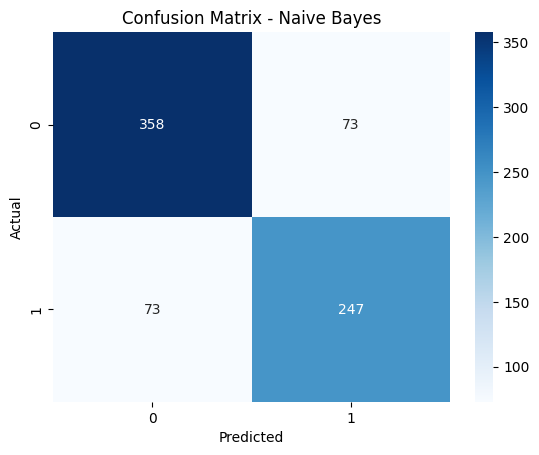

In [ ]:
cleaned_text = train_df['cleaned_text']
target = train_df['target']
model_nb, y_pred_nb, y_test, params = get_model_mnb(best_model_mnb, cleaned_text, target)

X_train_text, X_test_text, y_train, y_test = train_test_split(
        cleaned_text, target, test_size=0.1, random_state=99, stratify=target
    )
X_train_text
y_pred_test = get_pred_mnb(model_nb, params, X_test_text, y_test)
y_pred_train = get_pred_mnb(model_nb, params, X_train_text, y_train)
plot_cm(y_test, y_pred_test, "Confusion Matrix - Naive Bayes")


In [ ]:
df_training = train_df.loc[X_train_text.index]
df_test = train_df.loc[X_test_text.index]
df_training['predicted_nb'] = y_pred_train
df_test['predicted_nb'] = y_pred_test

## LR

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score # Import necessary metrics
import numpy as np

def get_model_lr(results, cleaned_text, target):
    params = results['params']
    use_hapus_kosong = results['use_hapus_kosong']
    use_selectkbest = results['use_selectkbest']
    k = results['k_chi']

    # Mapping string function names back to callable functions
    score_func_map = {
        '<function chi2 at 0x7ad2c6d2e2a0>': chi2, # Update address if necessary, or use a more robust mapping
        '<function f_classif at 0x7ad2c6d2e0c0>': f_classif, # Update address if necessary
        'chi2': chi2, # Add more robust mapping
        'f_classif': f_classif # Add more robust mapping
    }

    # Get the actual score function from the map
    score_func = score_func_map.get(params['selectk__score_func'], params['selectk__score_func']) # Use .get for safety

    # 1. Split train-test
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        cleaned_text, target, test_size=0.1, random_state=99, stratify=target
    )

    # 2. TF-IDF fit on train only
    vectorizer = TfidfVectorizer(
        ngram_range=tuple(params['tfidf__ngram_range']),
        max_df=params['tfidf__max_df'],
        min_df=params['tfidf__min_df'],
        sublinear_tf=params['tfidf__sublinear_tf'],
        smooth_idf=params['tfidf__smooth_idf'],
        stop_words=params['tfidf__stop_words']
    )
    X_train = vectorizer.fit_transform(X_train_text)
    X_test = vectorizer.transform(X_test_text)

    # 4. Optional: SelectKBest hanya dari X_train
    if use_selectkbest and k is not None and k < X_train.shape[1]: # Add check for k is not None
        selector = SelectKBest(score_func=score_func, k=k) # Use the actual function object
        X_train = selector.fit_transform(X_train, y_train)
        X_test = selector.transform(X_test)
    else:
        selector = None

    # 3. Optional: hapus kosong di training set
    if use_hapus_kosong:
        X_train, y_train = hapusKosong(X_train, y_train)
        # Jangan diterapkan ke test!

    # 5. Train model di X_train dan predict di X_test

    lr_params = {k.replace('clf__', ''): v for k, v in params.items() if k.startswith('clf__')}
    model = LogisticRegression(**lr_params)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    bahan = {}
    bahan['vectorizer'] = vectorizer
    bahan['selector'] = selector
    # bahan['use_hapus_kosong'] = use_hapus_kosong
    bahan['use_selectkbest'] = use_selectkbest

    return model, y_pred, y_test, bahan

def get_pred_lr(model, params, cleaned_text, target):
    # use_hapus_kosong = params['use_hapus_kosong']
    use_selectkbest = params['use_selectkbest']
    vectorizer = params['vectorizer']
    selector = params['selector']
    # TF-IDF
    X_test = vectorizer.transform(cleaned_text)
    if use_selectkbest:
        X_test = selector.transform(X_test)

    return model.predict(X_test)


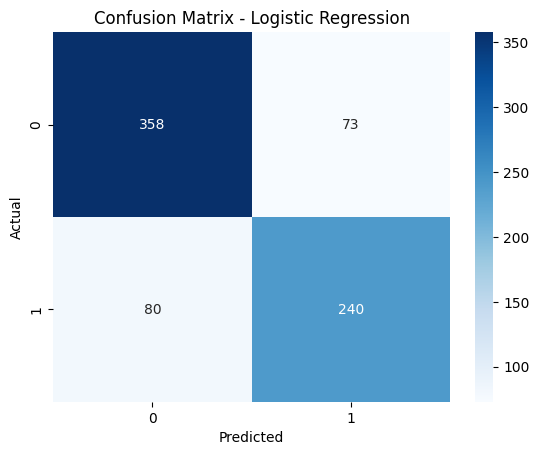

In [ ]:
cleaned_text = train_df['cleaned_text']
target = train_df['target']
model_lr, y_pred_lr, y_test, params_lr = get_model_lr(best_model_logreg, cleaned_text, target)

X_train_text, X_test_text, y_train, y_test = train_test_split(
        cleaned_text, target, test_size=0.1, random_state=99, stratify=target
    )

y_pred_test_lr = get_pred_lr(model_lr, params_lr, X_test_text, y_test)
y_pred_train_lr = get_pred_lr(model_lr, params_lr, X_train_text, y_train)
plot_cm(y_test, y_pred_test_lr, "Confusion Matrix - Logistic Regression")


In [ ]:
# df_training = train_df.loc[X_train_text.index]
# df_test = train_df.loc[X_test_text.index]
df_training['predicted_lr'] = y_pred_train_lr
df_test['predicted_lr'] = y_pred_test_lr

## df gabungan


In [ ]:
df_all = pd.concat([df_training, df_test])
print(df_all.shape)
df_all.head()

(7503, 8)


,id,keyword,location,text,target,cleaned_text,predicted_nb,predicted_lr
5811,8294,rubble,"Minna, Nigeria",China's Stock Market Crash: Are There Gems In ...,0,china 's stock market crash gem rubble chinaua...,0,0
2643,3795,destruction,NaN,RSS: Russia begins mass destruction of illegal...,1,rss russia mass destruction illegally import food,1,1
4435,6311,hostage,"Cape Neddick, ME",@EvaHanderek @MarleyKnysh great times until th...,1,evahanderek marleyknysh great time bus driver ...,0,0
5761,8223,riot,"Utah, USA",@ByTorrecilla Torrecilla We Always info the Se...,0,bytorrecilla torrecilla info secret lol game c...,0,0
3333,4774,evacuated,"Denver, Colorado",13000 evacuated as California firefighters fig...,1,evacuate california firefighter fight flame sa...,1,1


# Analisis Kesalahan Prediksi: Naive Bayes vs. Logistic Regression

In [ ]:
# --- Analisis Kesalahan Prediksi: Naive Bayes vs. Logistic Regression ---
# =======================================================================
# LANGKAH 5: MENYARING DAN MENAMPILKAN KESALAHAN
# =======================================================================
print("\n--- Analisis Kesalahan dan Perbedaan Prediksi ---")

# Kasus yang Anda minta: Target=1, NB salah (0), LR benar (1)
print("\nKasus di mana NB gagal mendeteksi bencana, tetapi LR berhasil:")
nb_miss_lr_correct = df_test[[
    'text', 'cleaned_text', 'target', 'predicted_nb', 'predicted_lr' # Corrected indexing here
]][
    (df_test['target'] == 1) &
    (df_test['predicted_nb'] == 0) &
    (df_test['predicted_lr'] == 1)
]
display(nb_miss_lr_correct)


--- Analisis Kesalahan dan Perbedaan Prediksi ---

Kasus di mana NB gagal mendeteksi bencana, tetapi LR berhasil:


,text,cleaned_text,target,predicted_nb,predicted_lr
4956,THE GLOBAL ECONOMIC MELTDOWN is out! http://t....,global economic meltdown story aleisstoke inte...,1,0,1
3477,GAElite 0 Explosion Greg 2 [Top 3rd] [0 Out...,gaelite explosion greg ball strike morgan orchard,1,0,1
1211,into burning fucking buildings (2/2),burn fucking building,1,0,1
3503,The gusto in persist had amongst empty-pated c...,gusto persist empty - pated communication expl...,1,0,1
4843,Another white guy trying to mass murder people...,white guy mass murder apparent reason guess 's...,1,0,1
1241,Such beautiful architecture in #NYC I love tho...,beautiful architecture love escape route build...,1,0,1
1640,... The pain of those seconds must have been a...,pain second awful heart burst lung collapse air,1,0,1
2478,Thanks a lot roadworks men cos a tube strike w...,lot roadwork cos tube strike not disruptive wa...,1,0,1
281,I know it's a question of interpretation but t...,'s question interpretation sign apocalypse call,1,0,1
6471,Japan FUSO Class Battleship YAMASHIRO Naval Co...,japan fuso class battleship yamashiro naval co...,1,0,1


In [ ]:
print(list(nb_miss_lr_correct['text']))

['THE GLOBAL ECONOMIC MELTDOWN is out! http://t.co/DGATKRdyNy Stories via @seagull07 @AleisStokes @intelligencebar', 'GAElite 0    Explosion Greg 2 [Top 3rd] [0 Out] [0 balls] [0 strikes] ... No one on [P: #16 Morgan Orchard] [B: ]', 'into burning fucking buildings (2/2)', 'The gusto in persist had amongst empty-pated communication explosion: hPSsJD', "Another white guy trying to mass murder people for no apparent reason just because let me guess he's mentally ill blah blah blah #Antioch", 'Such beautiful architecture in #NYC I love those fire escape routes on the buildings. #newyork\x89Û_ https://t.co/fW1PtaElgV', '... The pain of those seconds must have been awful as her heart burst and her lungs collapsed and there was no air and...', "Thanks a lot roadworks men cos a tube strike wasn't disruptive enough so having to walk the desolate route from Tottenham to .....", "I know it's a question of interpretation but this is a sign of the apocalypse.  I called it https://t.co/my8q1uWIjn",

**Analisis Singkat kalimat `Another white guy trying to mass murder people for no apparent reason just because let me guess he's mentally ill blah blah blah #Antioch`:**

Naive Bayes gagal karena kata-kata penting seperti “mass murder” dan “Antioch” mungkin jarang muncul bersamaan dalam data latih dan tidak cukup kuat secara individual. Logistic Regression berhasil karena mampu menangkap hubungan antar kata dan mengenali pola frasa yang mengindikasikan peristiwa bencana.



In [ ]:
# Sebagai tambahan, mari kita lihat kebalikannya: LR gagal, NB benar
print("\nKasus di mana LR gagal mendeteksi bencana, tetapi NB berhasil:")
lr_miss_nb_correct = df_test[[
    'text', 'cleaned_text', 'target', 'predicted_nb', 'predicted_lr' # Corrected indexing here
]][
    (df_test['target'] == 1) &
    (df_test['predicted_nb'] == 1) &
    (df_test['predicted_lr'] == 0)
]
display(lr_miss_nb_correct)


Kasus di mana LR gagal mendeteksi bencana, tetapi NB berhasil:


,text,cleaned_text,target,predicted_nb,predicted_lr
7138,@MrMikeEaton @Muazimus_Prime hill hill mountai...,mrmikeeaton muazimus_prime hill hill mountain ...,1,1,0
6568,Patient-reported outcomes in long-term survivo...,patient - report outcome long - term survivor ...,1,1,0
602,FedEx stops shipping potential bioterror patho...,fedex stop ship potential bioterror pathogen t...,1,1,0
3515,Interesting approach but doesn't replace Eyewi...,interesting approach not replace eyewitness vi...,1,1,0
6626,Truth...\nhttps://t.co/4ZQrsAQrRT\n#News\n#BBC...,truth news islam truth god terrorism quran lie,1,1,0
3339,Just got evacuated from the movie theatre for ...,evacuate movie theatre emergency run be,1,1,0
1121,'Redskins WR Roberts Belly-Bombed ' via @TeamS...,' redskins wr roberts belly - bomb teamstream,1,1,0
598,[JAX Biz Journal] FedEx stops shipping potenti...,jax journal fedex stop ship potential bioterro...,1,1,0
5103,Any disaster impairs mental health especially ...,disaster impairs mental health vulnerable indi...,1,1,0
1340,forestservice : RT dhsscitech: #Firefighters r...,forestservice dhsscitech firefighter burn buil...,1,1,0


In [ ]:
print(list(lr_miss_nb_correct['text']))

['@MrMikeEaton @Muazimus_Prime hill hill mountain volcano of hell mountain hill hil.', 'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt', 'FedEx stops shipping potential bioterror pathogens http://t.co/tkeOAeDQKq #trucking', "Interesting approach but doesn't replace Eyewitness video. The Ferguson Case - Video - http://t.co/vEcsoSRleR http://t.co/fiUOgj6hEF", 'Truth...\nhttps://t.co/4ZQrsAQrRT\n#News\n#BBC\n#CNN\n#Islam\n#Truth\n#god\n#ISIS\n#terrorism\n#Quran\n#Lies http://t.co/6ar3UKvsxw', "Just got evacuated from the movie theatre for an emergency. Saw people running from another they're.", "'Redskins WR Roberts Belly-Bombed ' via @TeamStream http://t.co/GbcvVEvDTY", '[JAX Biz Journal] FedEx stops shipping potential bioterror pathogens http://t.co/R33nCvjovC', 'Any disaster impairs mental health especially in vulnerable individuals... http://t.co/ZisuwLqRHf', 'forestservice : RT dhsscitech: #Firefigh

**Analisis Singkat kalimat `Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt`:**


Logistic Regression gagal karena menganggap konteksnya medis dan formal, sehingga bobot kata-kata seperti “survivors” atau “metastatic” tidak cukup kuat untuk diklasifikasikan sebagai bencana. Naive Bayes berhasil karena mengenali kata-kata seperti “survivors” dan “cancer” sebagai sinyal bencana berdasarkan frekuensi dalam data latih.


In [ ]:
# Dan kasus di mana keduanya sama-sama salah (False Negatives)
print("\nKasus di mana KEDUA model gagal mendeteksi bencana:")
both_miss = df_test[[
    'text', 'cleaned_text', 'target', 'predicted_nb', 'predicted_lr' # Corrected indexing here
]][
    (df_test['target'] == 1) &
    (df_test['predicted_nb'] == 0) &
    (df_test['predicted_lr'] == 0)
]
display(both_miss)


Kasus di mana KEDUA model gagal mendeteksi bencana:


,text,cleaned_text,target,predicted_nb,predicted_lr
3858,RP said they can see smoke coming from the sil...,rp smoke come silo street hartford flame,1,0,0
1653,Great British Bake Off's back and Dorret's cho...,great british bake 's dorret 's chocolate gate...,1,0,0
6239,@Habbo bring back games from the past. Snowsto...,habbo bring game snowstorm tic tac toe battles...,1,0,0
214,Annihilated Abs . ?? http://t.co/1xPw292tJe,annihilate ab,1,0,0
6837,Hollywood Movie About Trapped Miners Released ...,hollywood movie trap miner release chile ' the...,1,0,0
...,...,...,...,...,...
1906,Holy moly that was crushed.,holy moly crush,1,0,0
1454,@reriellechan HE WAS THE LICH KING'S FIRST CAS...,reriellechan lich king 's casualty block hate,1,0,0
4796,Jrowah: Breaking news! Unconfirmed! I just hea...,jrowah break news unconfirmed hear loud bang n...,1,0,0
4569,My baby girls car wreak this afternoon thank G...,baby girl car wreak afternoon god injury wear ...,1,0,0


In [ ]:
print(list(both_miss['text']))

['RP said they can see smoke coming from the silo on 260th Street in Hartford but no flames.', "Great British Bake Off's back and Dorret's chocolate gateau collapsed - JAN MOIR http://t.co/2SgDOFsmrQ http://t.co/xLEgC6UorA", '@Habbo bring back games from the past. Snowstorm. Tic tac toe. Battleships. Fast food. Matchwood.', 'Annihilated Abs . ?? http://t.co/1xPw292tJe', "Hollywood Movie About Trapped Miners Released in Chile: 'The 33' Hollywood movie about trapped miners starring... http://t.co/tyyfG4qQvM", 'UPDATE: 7 of the 9 Mac Pros my company bought in May have had catastrophe failures requiring repair!', "Hey #movietheatre mass murderer wanna-be we don't play that shit in the #615!", "Bloody hell it's already been upgraded to 'rioting'. #hyperbole #saintsfc", "Thunder pounds north goes black\na deep bruise on the sky's chest\nwind cries its pain.  \nA summer storm has a tough life\nshort violent.", '@IcyMagistrate \x89ÛÓher upper arm\x89ÛÒ those /friggin/ icicle projectiles\x89ÛÒ 

**Analisis Singkat kalimat `RP said they can see smoke coming from the silo on 260th Street in Hartford but no flames.`:**


Kedua model gagal karena tidak ada kata eksplisit seperti "fire" atau "explosion". Padahal frasa "smoke come" merupakan indikasi awal bencana. Model tidak cukup sensitif terhadap sinyal awal seperti asap tanpa api.



# Analisis Kesalahan Fokus pada Keyword 'ablaze'

Mengapa? karena `ablaze` memiliki 2 makna. makna kiasan dan makna yang sebenarnya. sehingga perlu dianalisis lebih lanjut secara sekilas dan singkat

In [ ]:
# --- Analisis Kesalahan Fokus pada Keyword 'ablaze' ---
# Pastikan sel sebelumnya yang membuat 'df_all' sudah dijalankan

print("Menampilkan semua kasus 'ablaze' dari data uji beserta prediksinya:")

# Pertama, mari kita lihat semua tweet 'ablaze' di data uji Anda untuk konteks
ablaze_cases_all = df_all[df_all['text'].str.contains('ablaze', case=False, na=False)]
display(ablaze_cases_all)

Menampilkan semua kasus 'ablaze' dari data uji beserta prediksinya:


,id,keyword,location,text,target,cleaned_text,predicted_nb,predicted_lr
55,79,ablaze,USA,#Kurds trampling on Turkmen flag later set it ...,1,kurd trample turkman flag set ablaze vandalize...,1,1
66,95,ablaze,San Francisco,@ablaze what time does your talk go until? I d...,0,ablaze time talk not work,0,0
50,73,ablaze,"Sheffield Township, Ohio",Deputies: Man shot before Brighton home set ab...,1,deputy shoot brighton set ablaze,1,1
61,86,ablaze,Inang Pamantasan,Progressive greetings!\n\nIn about a month stu...,0,progressive greeting month student set pen abl...,0,0
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1,inec office abia set ablaze,1,1
53,77,ablaze,Anaheim,Police: Arsonist Deliberately Set Black Church...,1,police arsonist deliberately set black church ...,1,1
46,66,ablaze,"GREENSBORO,NORTH CAROLINA",How the West was burned: Thousands of wildfire...,1,west burn thousand wildfire ablaze california,1,1
36,54,ablaze,Pretoria,@PhDSquares #mufc they've built so much hype a...,0,phdsquares mufc build hype acquisition doubt s...,0,0
42,62,ablaze,milky way,Had an awesome time visiting the CFC head offi...,0,awesome time visit cfc head office ancop site ...,0,0
39,57,ablaze,Paranaque City,Ablaze for you Lord :D,0,ablaze lord,0,0


In [ ]:
# Sekarang, kita filter berdasarkan jenis kesalahan seperti yang Anda minta
print("\n--- Analisis Kesalahan Spesifik pada Kasus 'ablaze' ---")

# Kasus: Target=1 (Bencana), NB salah (0), LR benar (1)
print("\nKasus 'ablaze' di mana NB gagal mendeteksi bencana, tetapi LR berhasil:")
nb_miss_lr_correct_ablaze = df_all[[
    'text', 'target', 'predicted_nb', 'predicted_lr' # Corrected indexing here
]][
    (df_all['target'] == 1) &
    (df_all['predicted_nb'] == 0) &
    (df_all['predicted_lr'] == 1) &
    (df_all['text'].str.contains('ablaze', case=False, na=False)) # Filter tambahan
]
if nb_miss_lr_correct_ablaze.empty:
    print("Tidak ditemukan kasus yang cocok.")
else:
    display(nb_miss_lr_correct_ablaze)


--- Analisis Kesalahan Spesifik pada Kasus 'ablaze' ---

Kasus 'ablaze' di mana NB gagal mendeteksi bencana, tetapi LR berhasil:
Tidak ditemukan kasus yang cocok.


In [ ]:
# Sekarang, kita filter berdasarkan jenis kesalahan seperti yang Anda minta
print("\n--- Analisis Kesalahan Spesifik pada Kasus 'ablaze' ---")

# Kasus: Target=1 (Bencana), NB benar (1), LR salah (0)
print("\nKasus 'ablaze' di mana LR gagal mendeteksi bencana, tetapi NB berhasil:")
nb_miss_lr_correct_ablaze = df_all[[
    'text', 'target', 'predicted_nb', 'predicted_lr' # Corrected indexing here
]][
    (df_all['target'] == 1) &
    (df_all['predicted_nb'] == 1) &
    (df_all['predicted_lr'] == 0) &
    (df_all['text'].str.contains('ablaze', case=False, na=False)) # Filter tambahan
]
if nb_miss_lr_correct_ablaze.empty:
    print("Tidak ditemukan kasus yang cocok.")
else:
    display(nb_miss_lr_correct_ablaze)


--- Analisis Kesalahan Spesifik pada Kasus 'ablaze' ---

Kasus 'ablaze' di mana LR gagal mendeteksi bencana, tetapi NB berhasil:
Tidak ditemukan kasus yang cocok.


In [ ]:
# Kasus: Target=0 (Bukan Bencana), tetapi kedua model salah tebak (False Positive)
print("\nKasus 'ablaze' (metafora) di mana KEDUA model salah menebak sebagai bencana:")
both_false_positive_ablaze = df_all[[
    'text', 'cleaned_text', 'target', 'predicted_nb', 'predicted_lr' # Corrected indexing here
]][
    (df_all['target'] == 0) &
    (df_all['predicted_nb'] == 1) &
    (df_all['predicted_lr'] == 1) &
    (df_all['text'].str.contains('ablaze', case=False, na=False)) # Filter tambahan
]
if both_false_positive_ablaze.empty:
    print("Tidak ditemukan kasus yang cocok.")
else:
    display(both_false_positive_ablaze)


Kasus 'ablaze' (metafora) di mana KEDUA model salah menebak sebagai bencana:


,text,cleaned_text,target,predicted_nb,predicted_lr
34,Crying out for more! Set me ablaze,cry set ablaze,0,1,1
44,I wanted to set Chicago ablaze with my preachi...,wanted set chicago ablaze preach hotel,0,1,1


**Analisis Singkat kalimat `Crying out for more! Set me ablaze`:**

Kedua model salah karena menganggap kata “ablaze” sebagai tanda bencana. Padahal konteksnya metaforis—ungkapan emosional atau spiritual, bukan kejadian nyata. Model gagal menangkap makna kiasan.

In [ ]:
# Kasus: Model tidak sepakat tentang tweet 'ablaze'
print("\nKasus 'ablaze' di mana prediksi NB dan LR TIDAK SEPAKAT:")
disagreement_ablaze = df_all[[
    'text', 'cleaned_text', 'target', 'predicted_nb', 'predicted_lr' # Corrected indexing here
]][
    (df_all['predicted_nb'] != df_all['predicted_lr']) &
    (df_all['text'].str.contains('ablaze', case=False, na=False)) # Filter tambahan
]
if disagreement_ablaze.empty:
    print("Tidak ditemukan kasus di mana model tidak sepakat.")
else:
    display(disagreement_ablaze)


Kasus 'ablaze' di mana prediksi NB dan LR TIDAK SEPAKAT:


,text,cleaned_text,target,predicted_nb,predicted_lr
41,on the outside you're ablaze and alive\nbut yo...,be ablaze alive be dead inside,0,1,0
58,They sky was ablaze tonight in Los Angeles. I'...,sky ablaze tonight angeles ' m expect ig fb fi...,0,1,0


**Analisis Singkat kalimat `on the outside you're ablaze and alive but you're dead inside`:**

Naive Bayes mungkin mengklasifikasikan sebagai bencana karena kata “ablaze” punya probabilitas tinggi terkait bencana. Logistic Regression cenderung tidak karena mengenali konteks emosional dan abstrak dari frasa, bukan kejadian nyata.


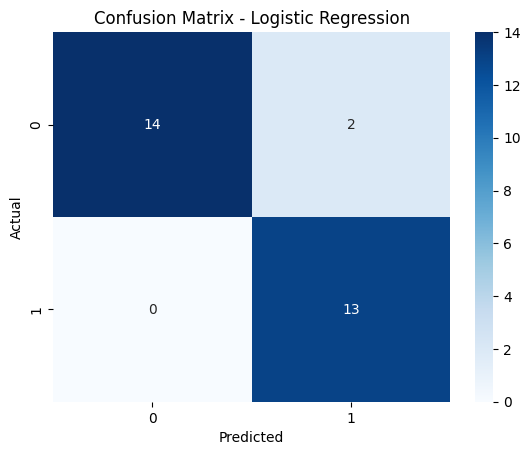

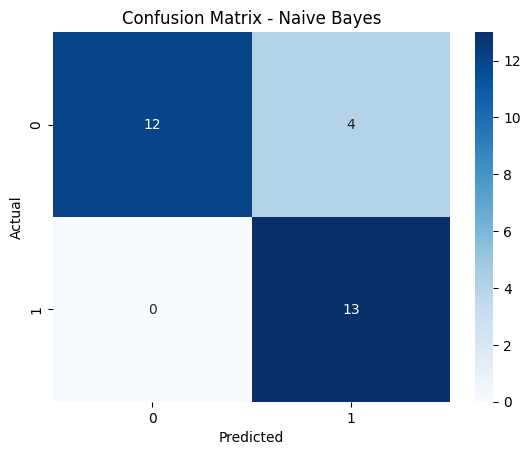

In [ ]:
plot_cm(ablaze_cases_all['target'], ablaze_cases_all['predicted_lr'], "Confusion Matrix - Logistic Regression")
plot_cm(ablaze_cases_all['target'], ablaze_cases_all['predicted_nb'], "Confusion Matrix - Naive Bayes")


# Model interpretability (menggunakan sequence labeling untuk mencari informasi mengenai lokasi terjadi bencana menggunakan NER (Named Entity Recognition))

### informasi mengenai lokasi terjadi bencana (top 15)

In [ ]:
# Load model NER dari spacy
nlp = spacy.load("en_core_web_sm")

# 1. Pilih DataFrame hasil dari model terbaik
# Using df_all which contains both training and test data with predictions
df_terbaik = df_all.copy()

# 2. Filter only for tweets predicted as DISASTER by *both* models
# Or you could choose to filter based on the best performing model identified earlier (e.g., 'predicted_lr')
df_bencana_pred = df_terbaik[[
    'text', 'predicted_nb', 'predicted_lr'
]][
    (df_terbaik['predicted_nb'] == 1) | (df_terbaik['predicted_lr'] == 1) # Filter for tweets predicted as disaster by EITHER model
].copy()


# 3. Buat fungsi untuk ekstraksi lokasi menggunakan NER
def get_locations(text):
    if pd.isna(text): # Handle potential NaN values in text column
        return None
    doc = nlp(text)
    locations = [ent.text for ent in doc.ents if ent.label_ in ['GPE', 'LOC']]
    # Mengembalikan daftar lokasi unik jika ditemukan, jika tidak kembalikan None
    return list(set(locations)) if locations else None

# 4. Terapkan fungsi NER pada kolom teks asli
df_bencana_pred['lokasi_ditemukan'] = df_bencana_pred['text'].apply(get_locations)

# 5. Tampilkan hasilnya (hanya yang berhasil menemukan lokasi)
print("Contoh Teks Bencana dan Lokasi yang Ditemukan oleh NER:")
display(df_bencana_pred.dropna(subset=['lokasi_ditemukan']).sample(10))

Contoh Teks Bencana dan Lokasi yang Ditemukan oleh NER:


,text,predicted_nb,predicted_lr,lokasi_ditemukan
2748,In Kalmikya Astrakhan Volgagrad and Dagestan t...,1,0,[Dagestan]
1150,@snapharmony : Bells toll in Hiroshima as Japa...,1,1,"[Japan, Hiroshima]"
4112,Calgary news weather and traffic for August 5 ...,1,0,[Calgary]
5604,The Latest: More Homes Razed by Northern Calif...,1,1,[Northern California Wildfire -]
6234,Sassy city girl country hunk stranded in Smoky...,1,1,[Smoky Mountain]
1414,Civilian Casualties in Afghanistan Reach Recor...,1,1,[Afghanistan]
1829,Pakistan says army helicopter has crashed in c...,1,1,[Pakistan]
1691,When Houston and NYC collide. ?? @pageparkesco...,1,1,[Houston]
1144,Japan Marks 70th Anniversary of Hiroshima Atom...,1,1,"[Japan, Hiroshima]"
12,#raining #flooding #Florida #TampaBay #Tampa 1...,1,1,[Florida]


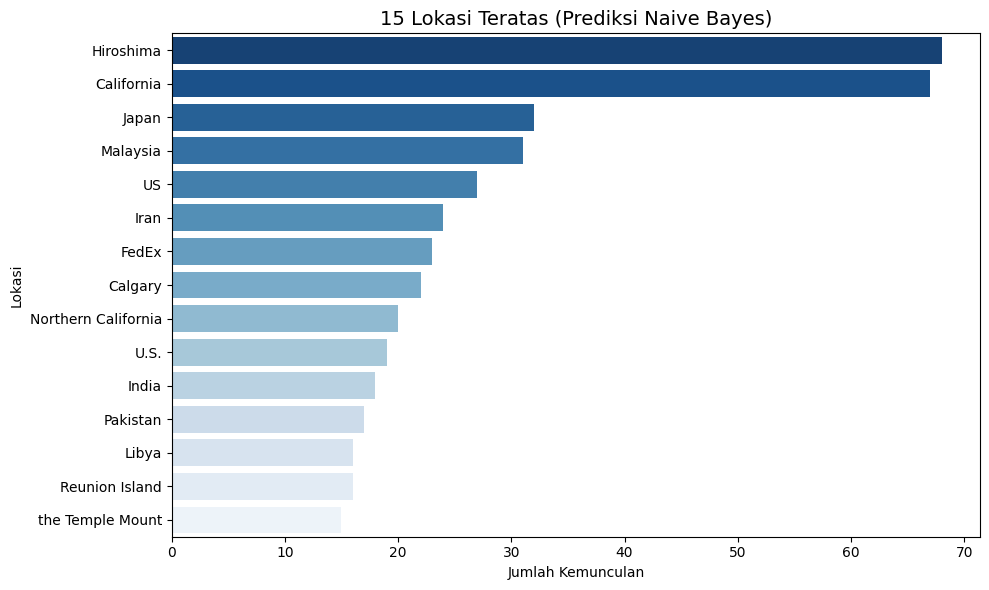

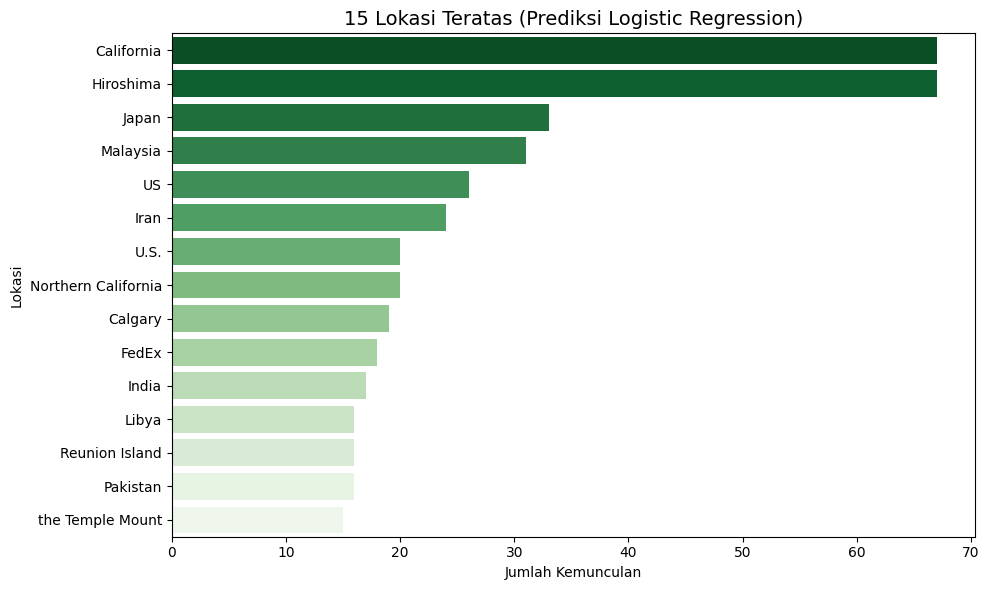

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Ambil lokasi dari prediksi Naive Bayes
df_bencana_nb = df_bencana_pred[df_bencana_pred['predicted_nb'] == 1].copy()
lokasi_nb = df_bencana_nb['lokasi_ditemukan'].dropna().explode()
top15_nb = Counter(lokasi_nb).most_common(15)
df_top15_nb = pd.DataFrame(top15_nb, columns=['Lokasi', 'Jumlah'])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_top15_nb, y='Lokasi', x='Jumlah', palette='Blues_r')
plt.title('15 Lokasi Teratas (Prediksi Naive Bayes)', fontsize=14)
plt.xlabel('Jumlah Kemunculan')
plt.ylabel('Lokasi')
plt.tight_layout()
plt.show()


# Ambil lokasi dari prediksi Logistic Regression
df_bencana_lr = df_bencana_pred[df_bencana_pred['predicted_lr'] == 1].copy()
lokasi_lr = df_bencana_lr['lokasi_ditemukan'].dropna().explode()
top15_lr = Counter(lokasi_lr).most_common(15)
df_top15_lr = pd.DataFrame(top15_lr, columns=['Lokasi', 'Jumlah'])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_top15_lr, y='Lokasi', x='Jumlah', palette='Greens_r')
plt.title('15 Lokasi Teratas (Prediksi Logistic Regression)', fontsize=14)
plt.xlabel('Jumlah Kemunculan')
plt.ylabel('Lokasi')
plt.tight_layout()
plt.show()


### informasi mengenai waktu terjadi bencana (top 15)

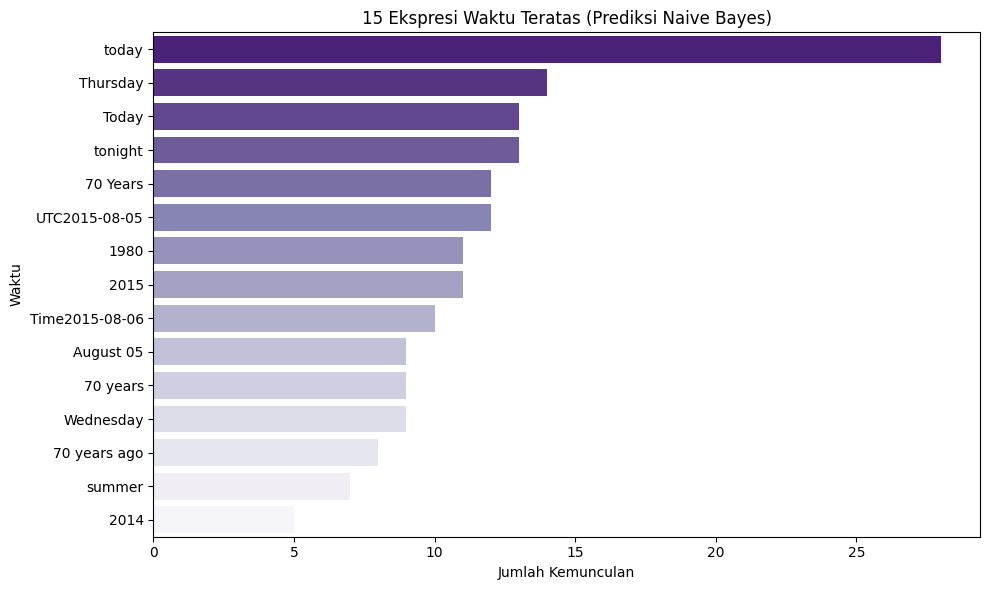

In [ ]:
def get_waktu(text):
    if pd.isna(text):
        return None
    doc = nlp(text)
    waktu = [ent.text for ent in doc.ents if ent.label_ in ['DATE', 'TIME']]
    return list(set(waktu)) if waktu else None

# Ekstrak waktu dari tweet yang diprediksi Naive Bayes
df_bencana_nb['waktu_ditemukan'] = df_bencana_nb['text'].apply(get_waktu)

# Ekstrak waktu dari tweet yang diprediksi Logistic Regression
df_bencana_lr['waktu_ditemukan'] = df_bencana_lr['text'].apply(get_waktu)


from collections import Counter

waktu_nb = df_bencana_nb['waktu_ditemukan'].dropna().explode()
top15_waktu_nb = Counter(waktu_nb).most_common(15)
df_top15_waktu_nb = pd.DataFrame(top15_waktu_nb, columns=['Waktu', 'Jumlah'])


waktu_lr = df_bencana_lr['waktu_ditemukan'].dropna().explode()
top15_waktu_lr = Counter(waktu_lr).most_common(15)
df_top15_waktu_lr = pd.DataFrame(top15_waktu_lr, columns=['Waktu', 'Jumlah'])


plt.figure(figsize=(10, 6))
sns.barplot(data=df_top15_waktu_nb, y='Waktu', x='Jumlah', palette='Purples_r')
plt.title('15 Ekspresi Waktu Teratas (Prediksi Naive Bayes)')
plt.xlabel('Jumlah Kemunculan')
plt.ylabel('Waktu')
plt.tight_layout()
plt.show()





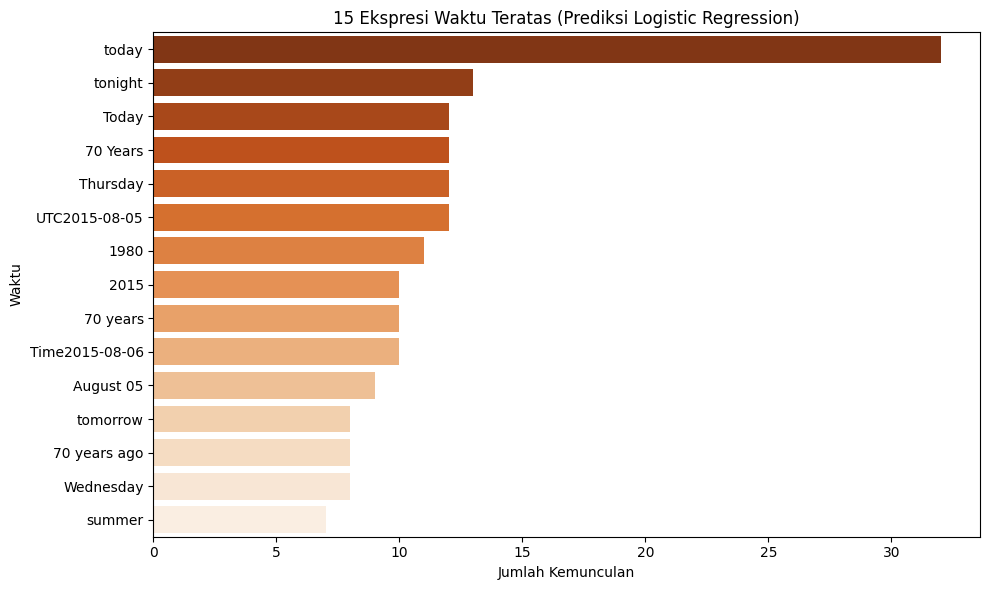

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_top15_waktu_lr, y='Waktu', x='Jumlah', palette='Oranges_r')
plt.title('15 Ekspresi Waktu Teratas (Prediksi Logistic Regression)')
plt.xlabel('Jumlah Kemunculan')
plt.ylabel('Waktu')
plt.tight_layout()
plt.show()
